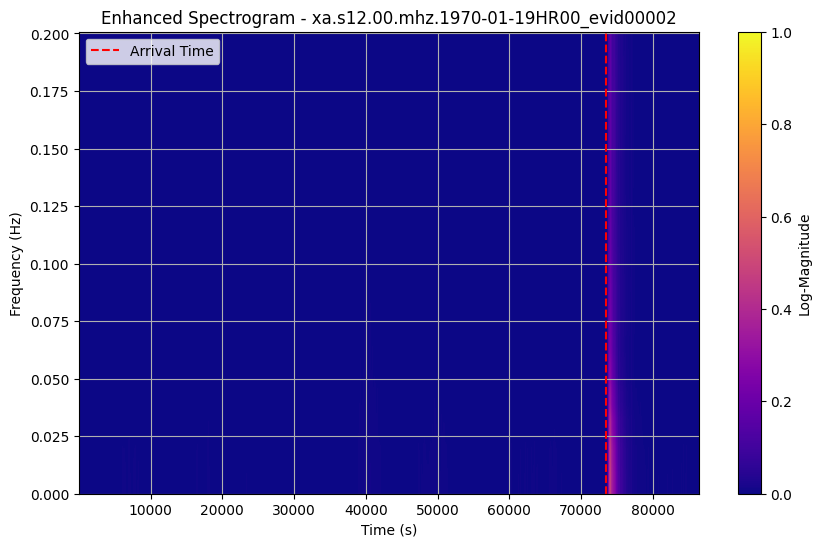

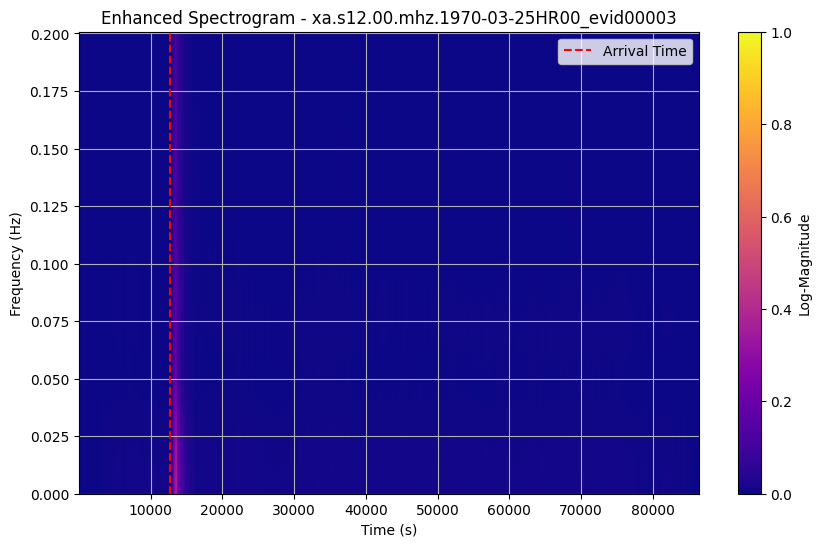

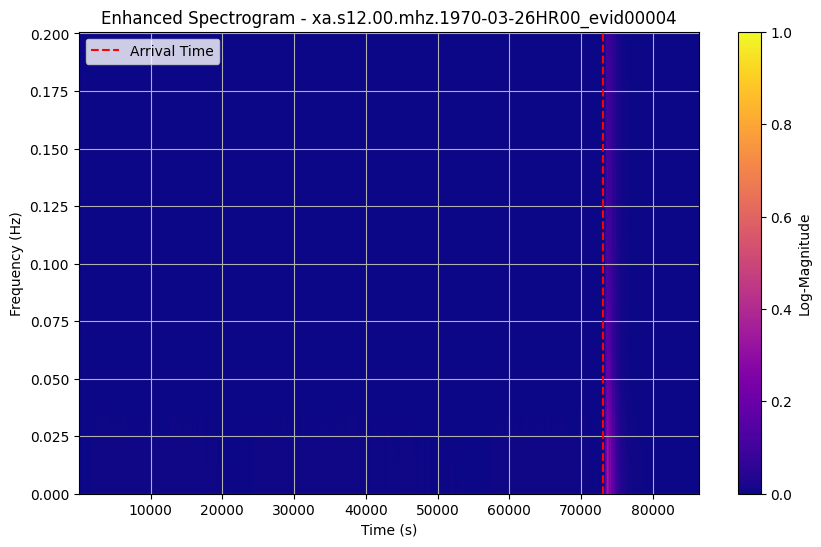

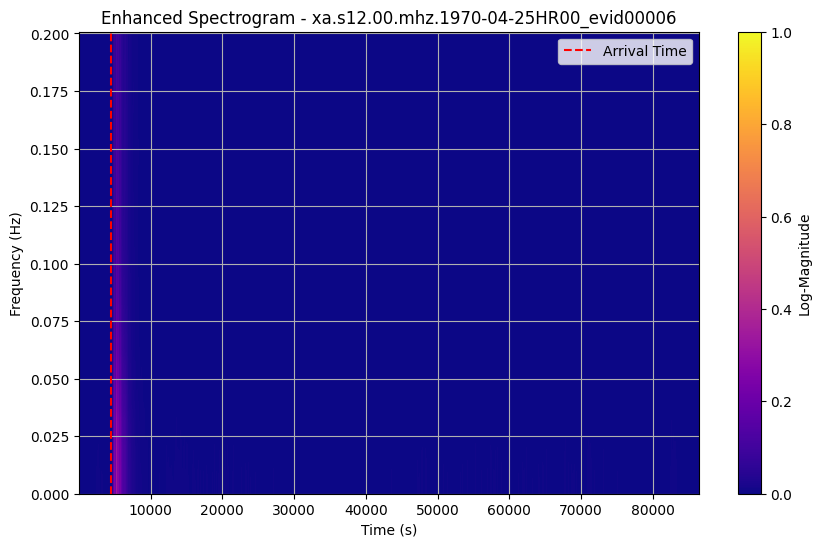

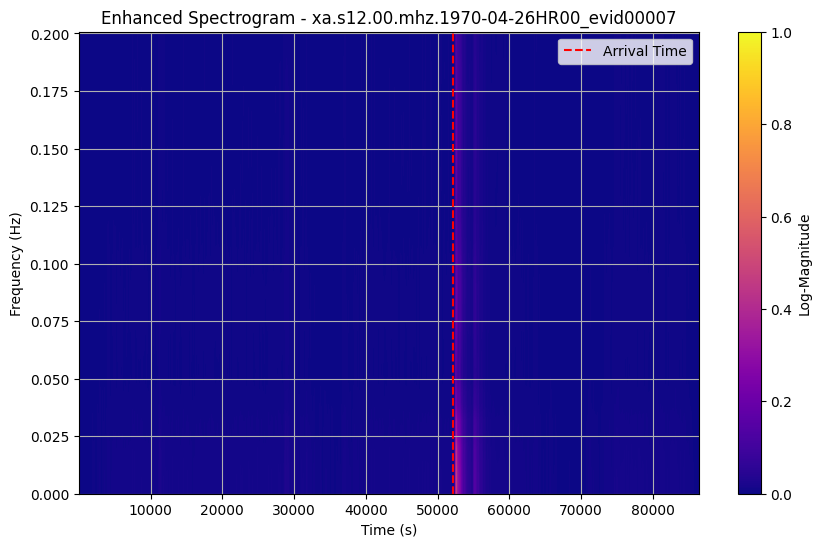

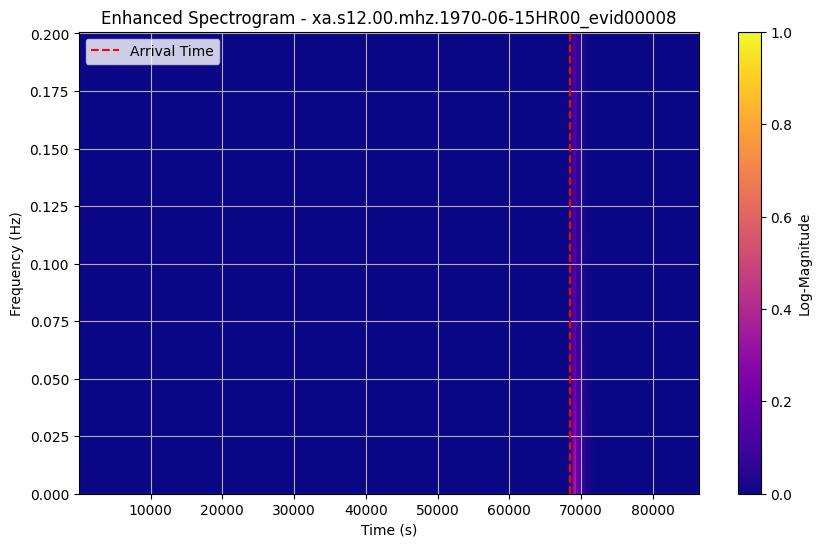

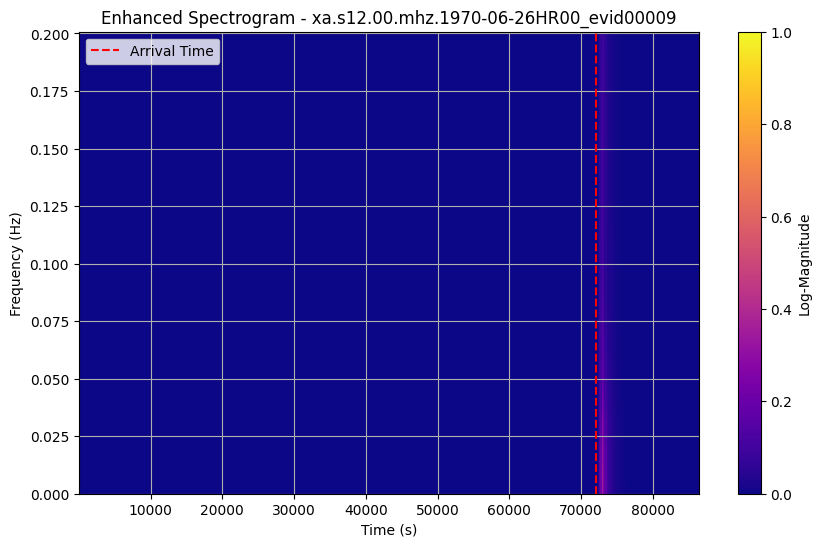

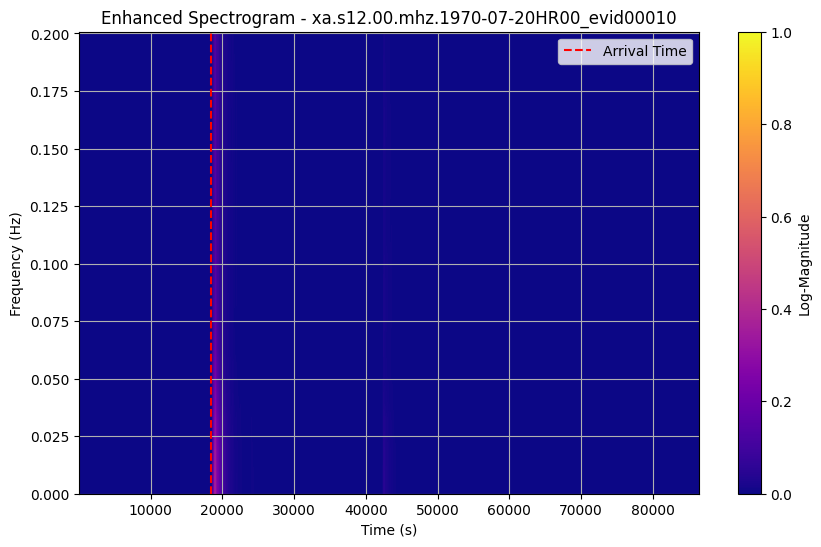

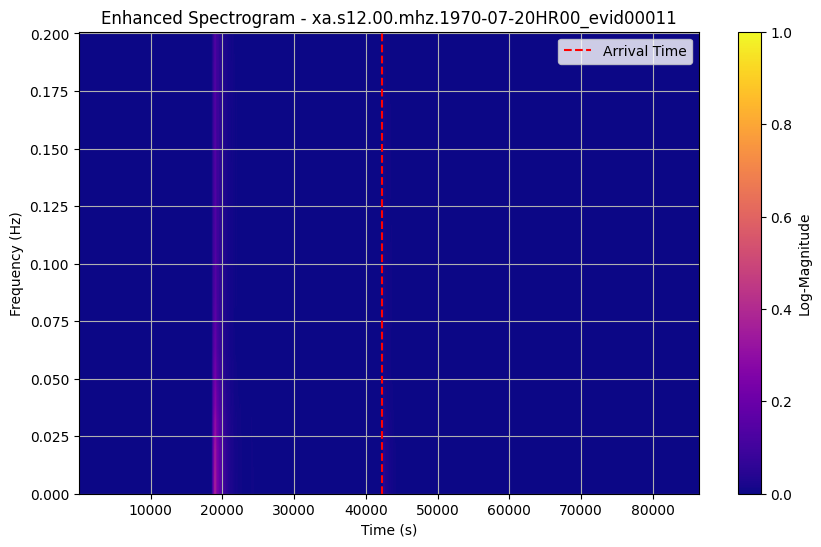

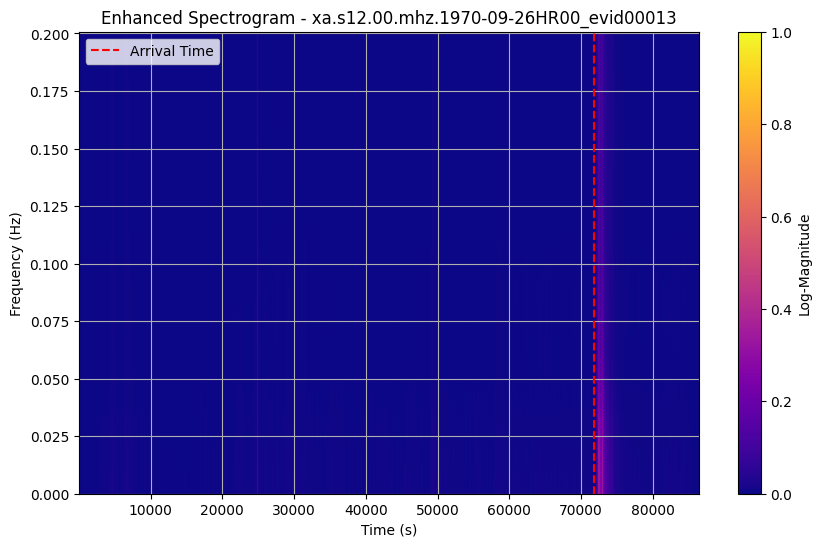

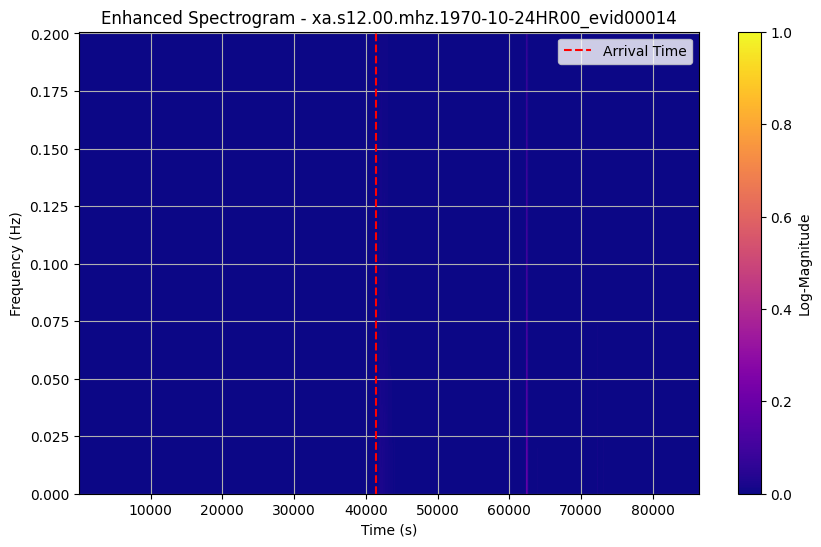

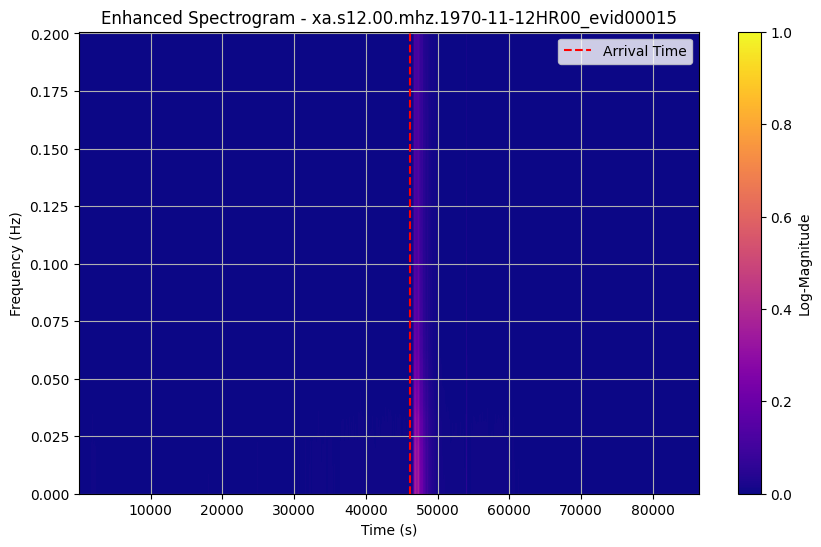

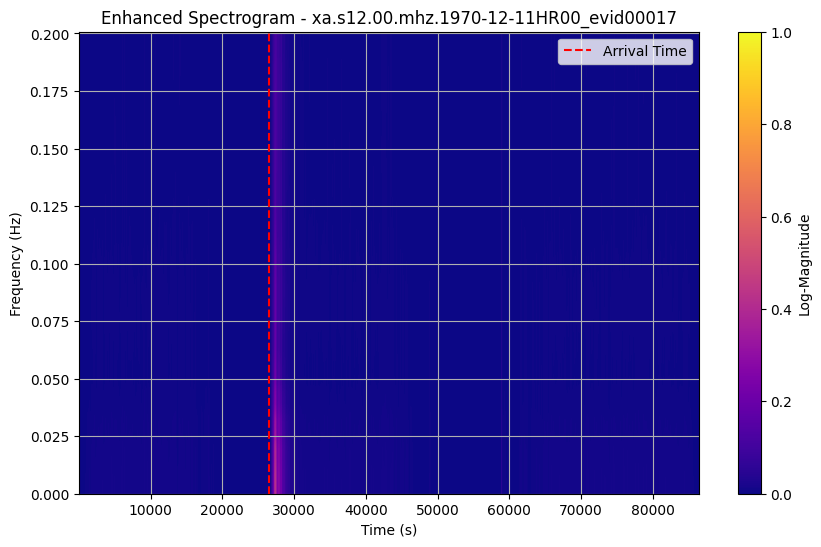

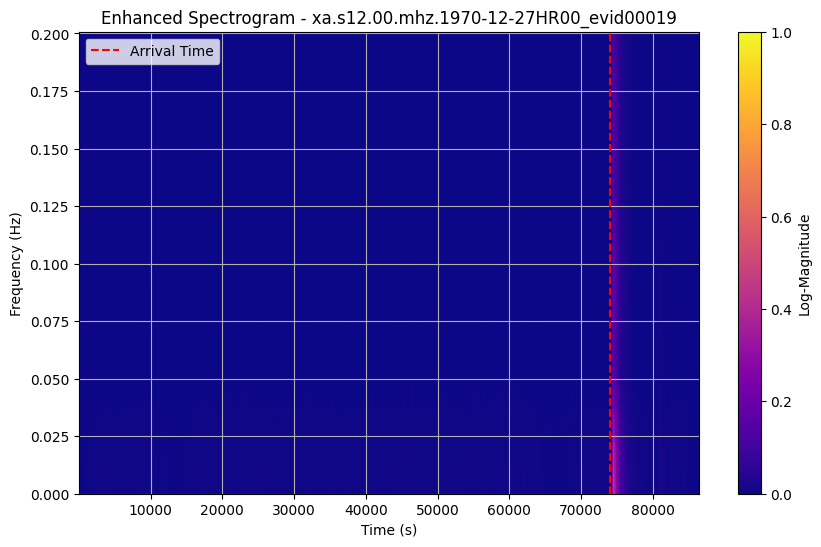

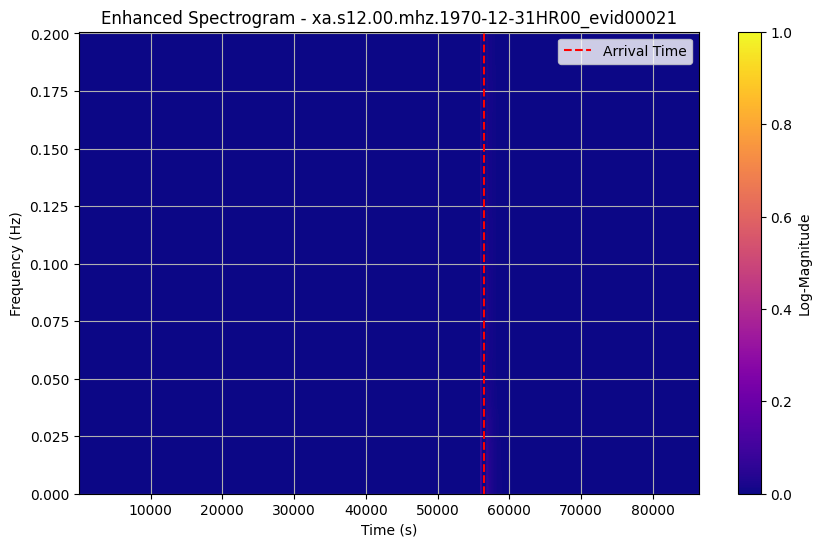

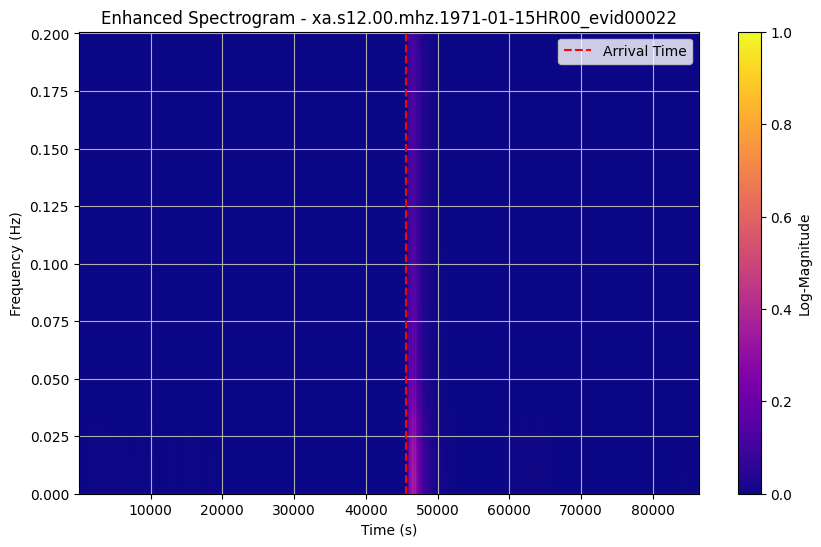

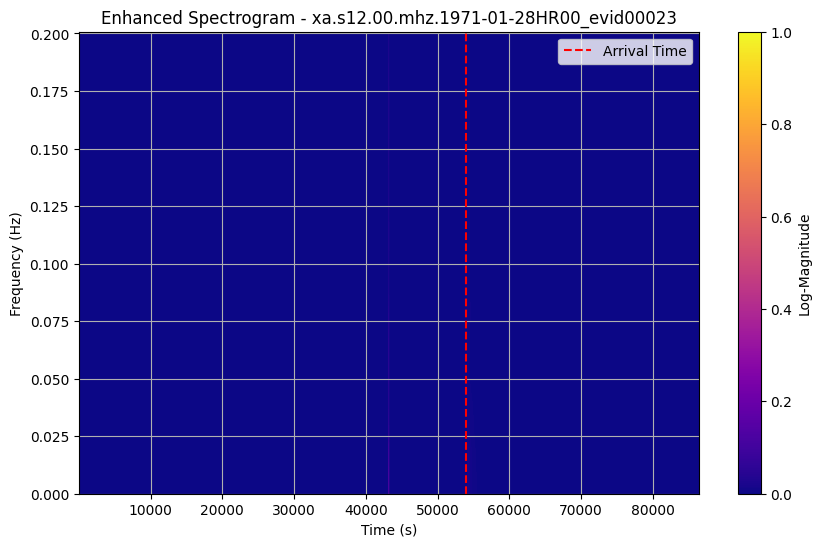

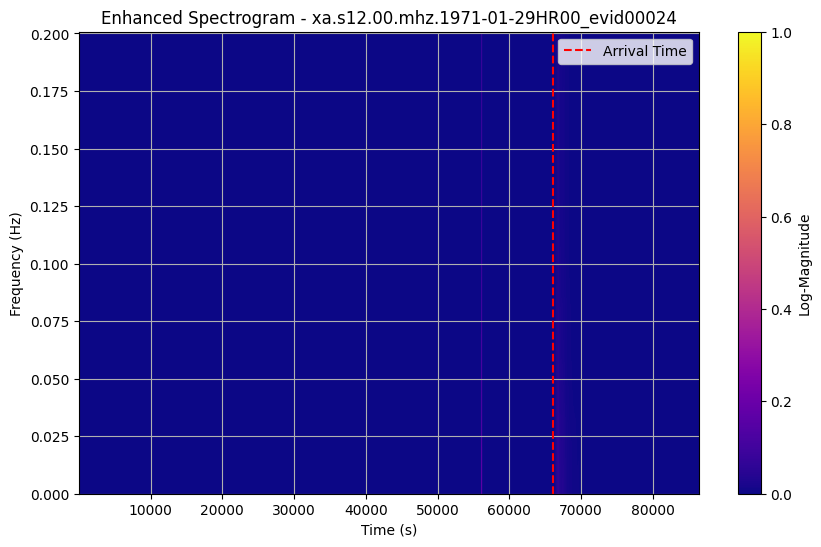

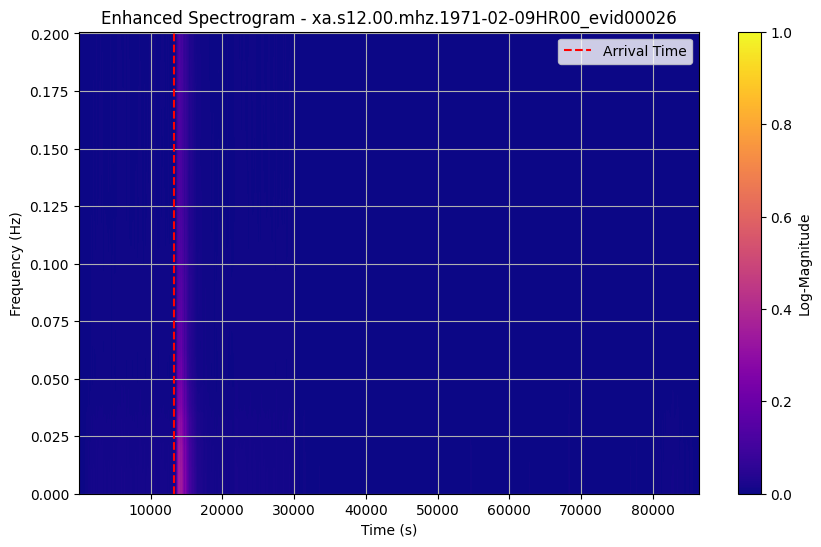

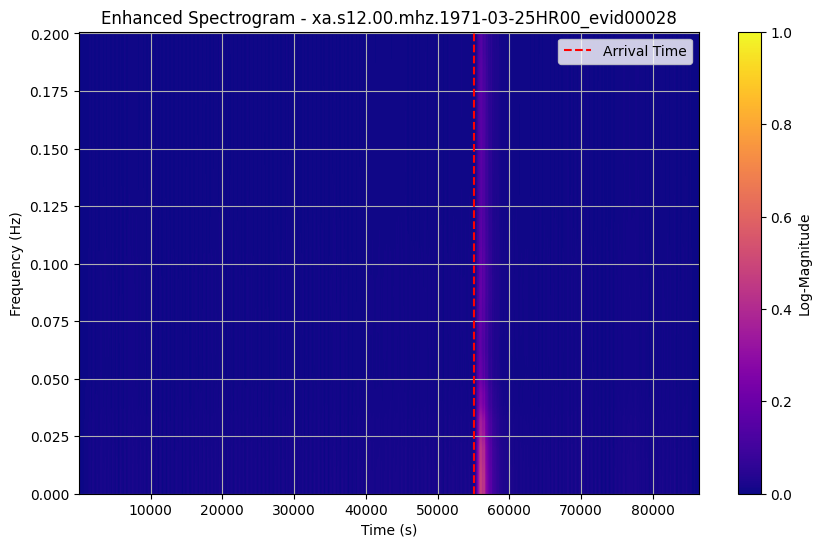

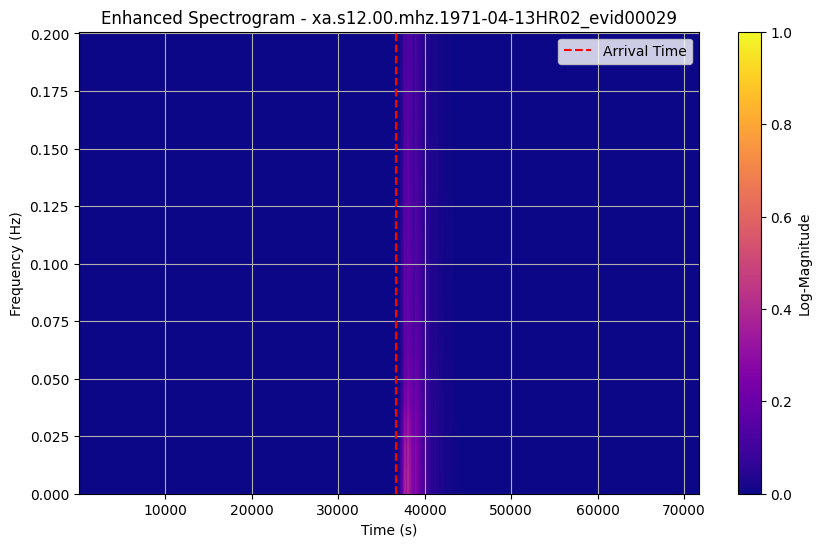

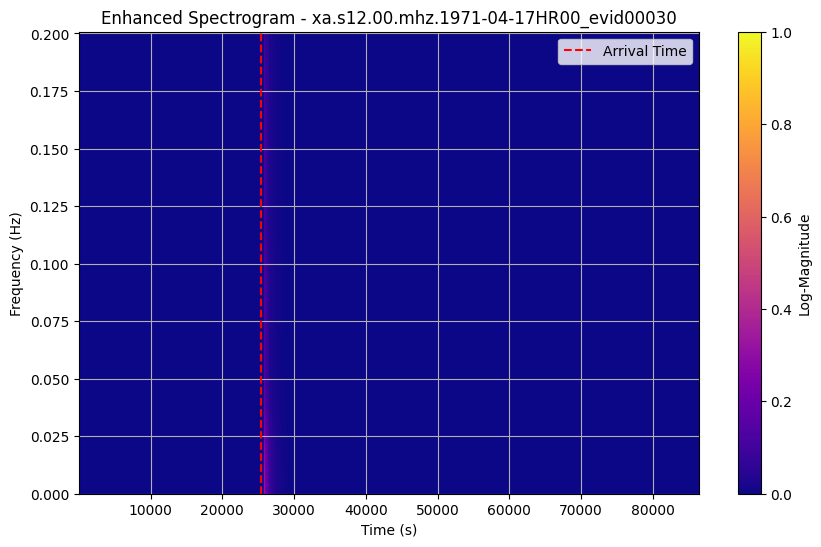

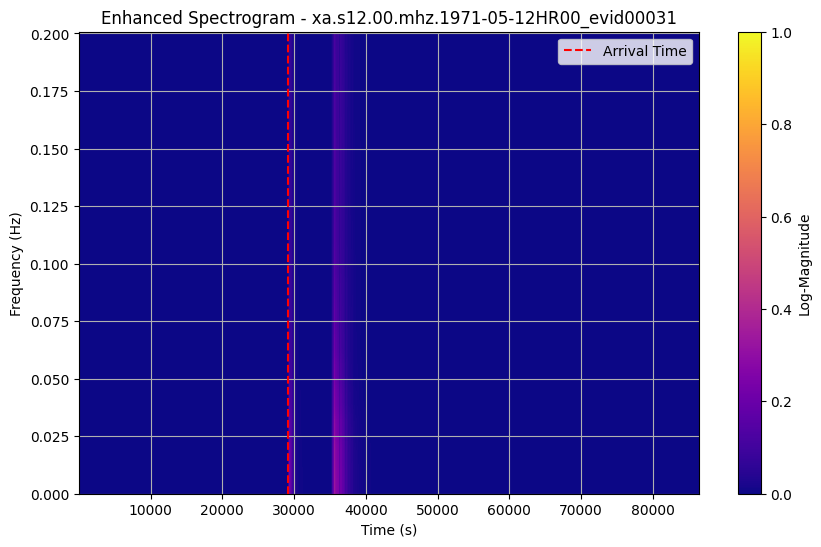

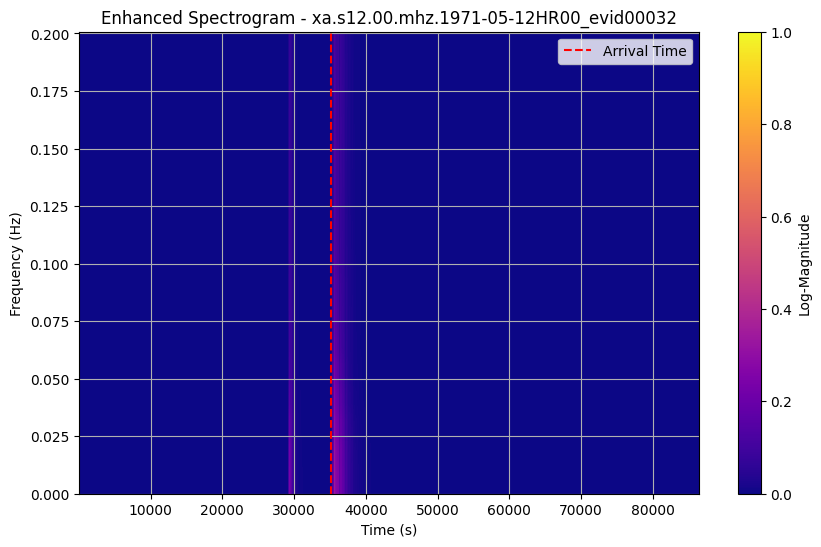

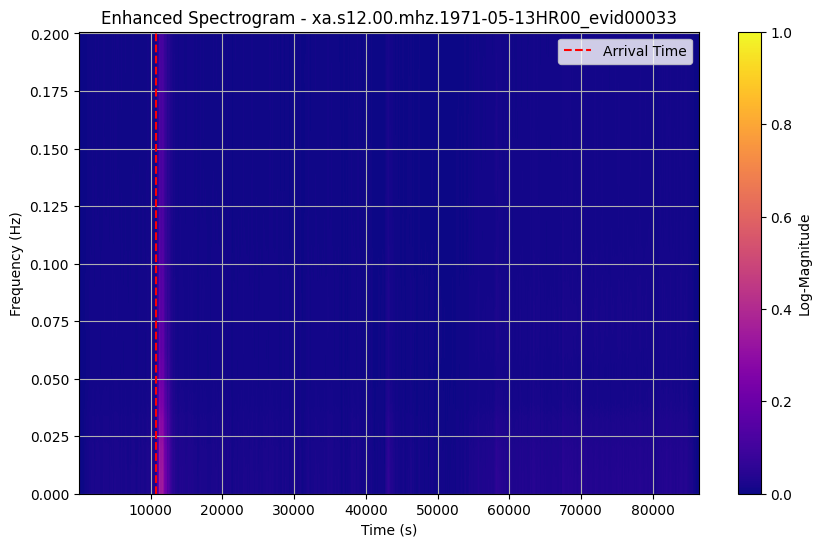

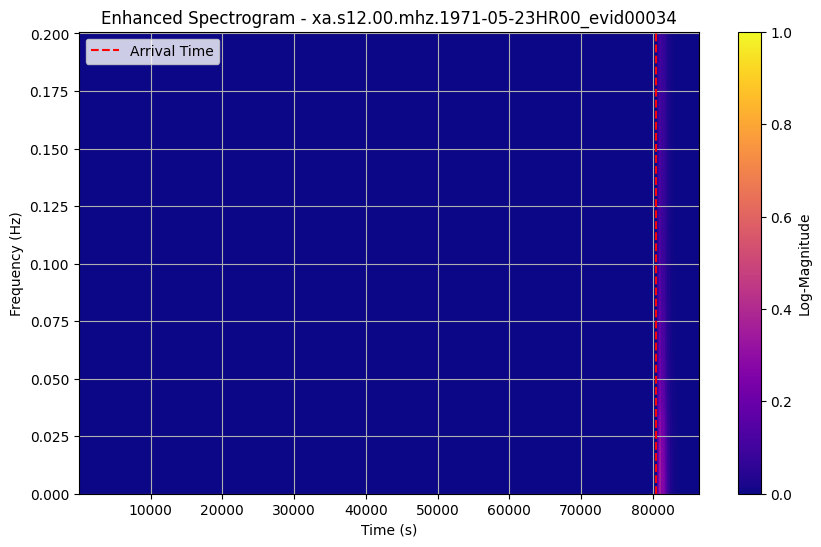

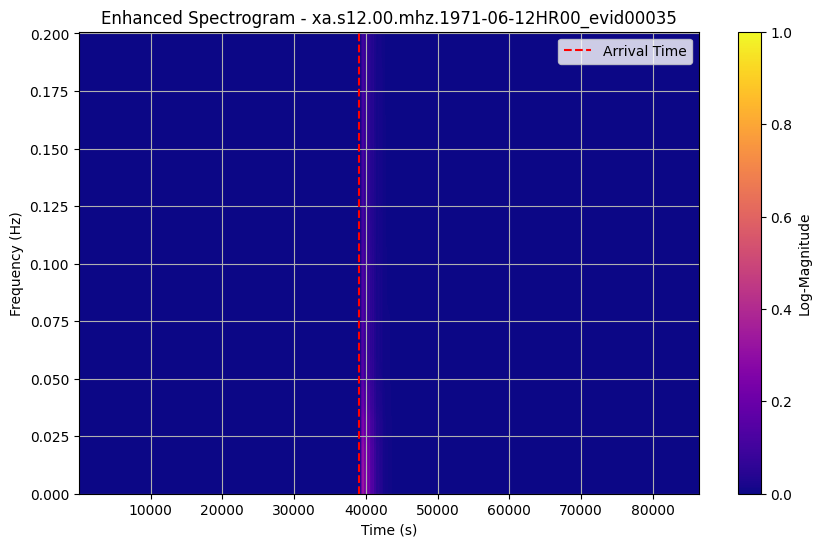

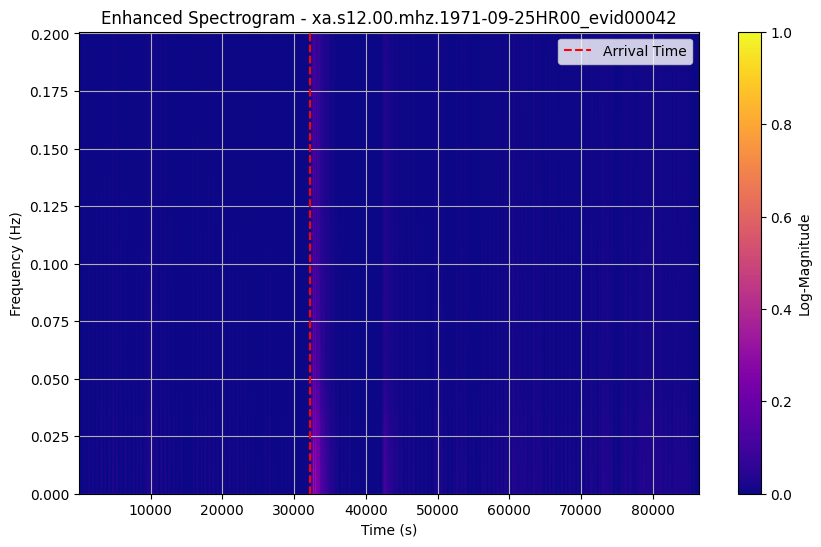

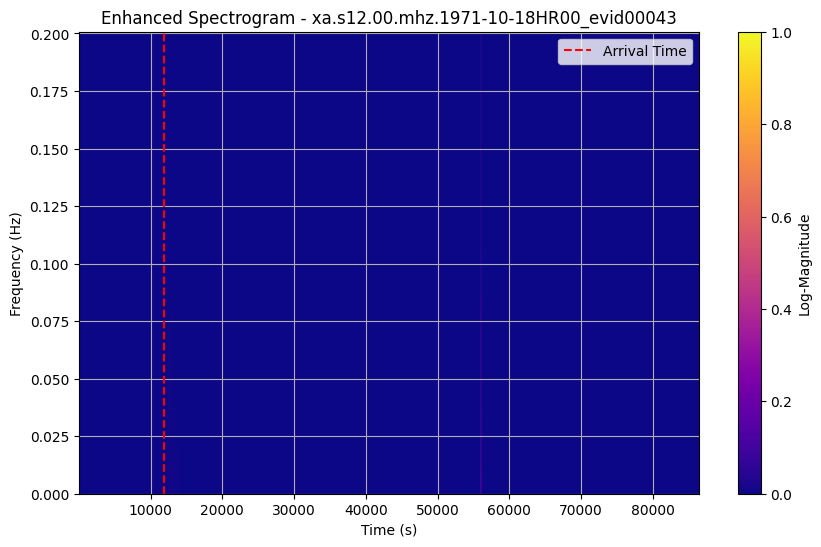

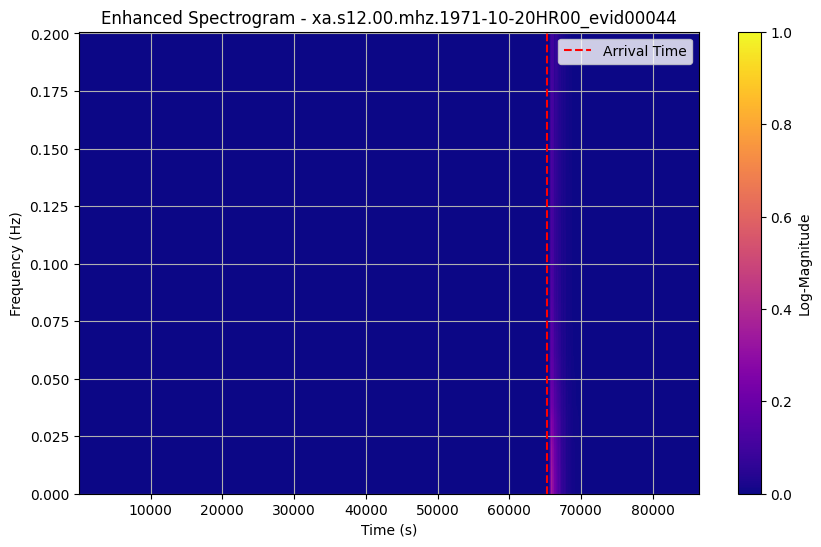

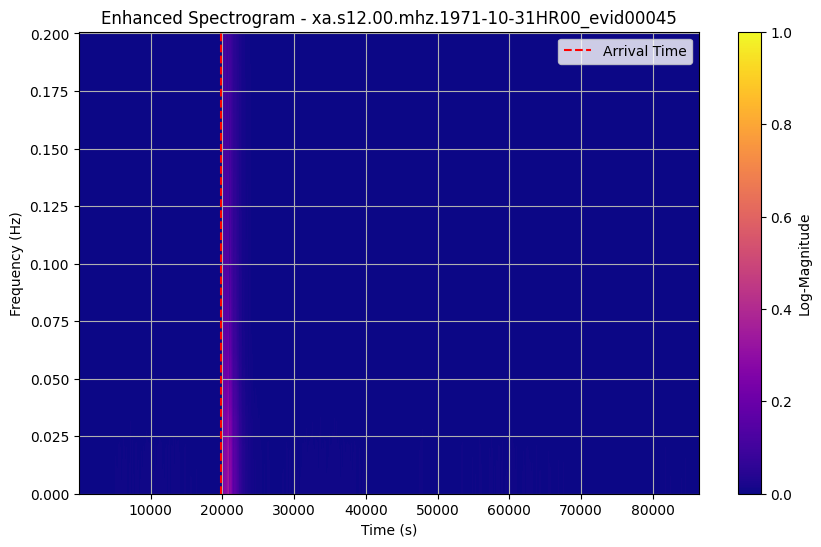

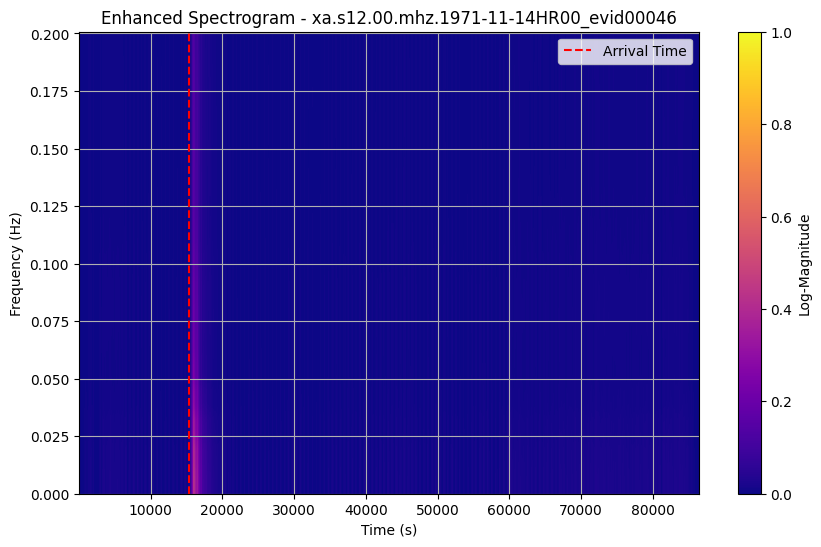

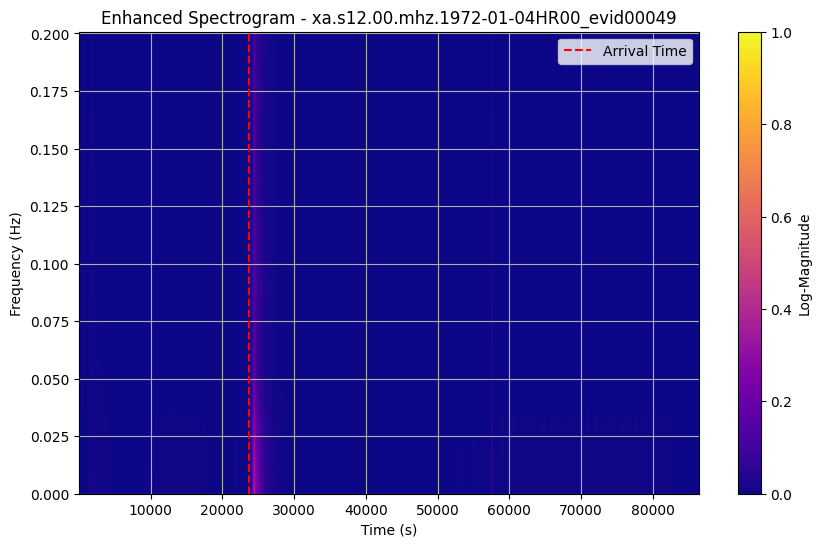

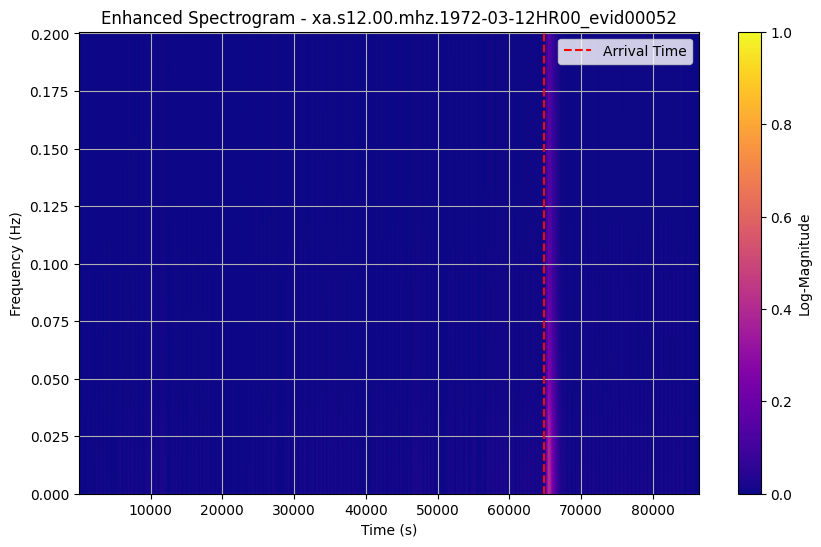

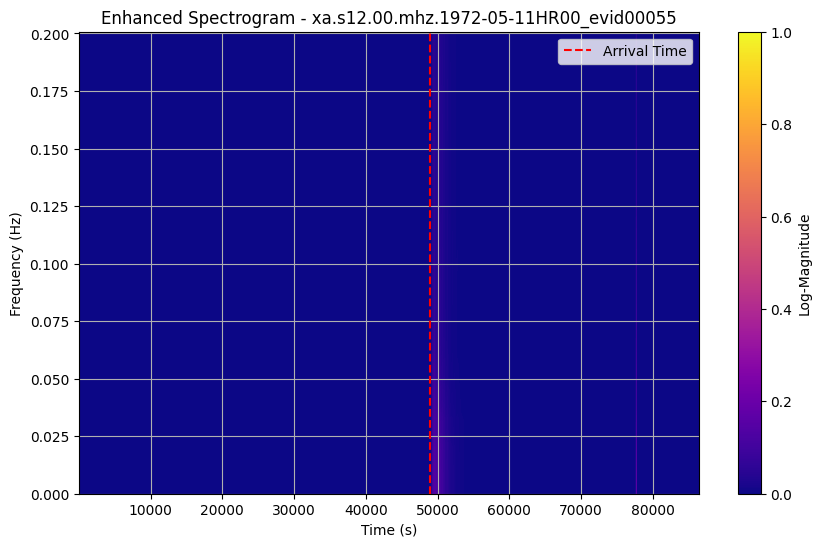

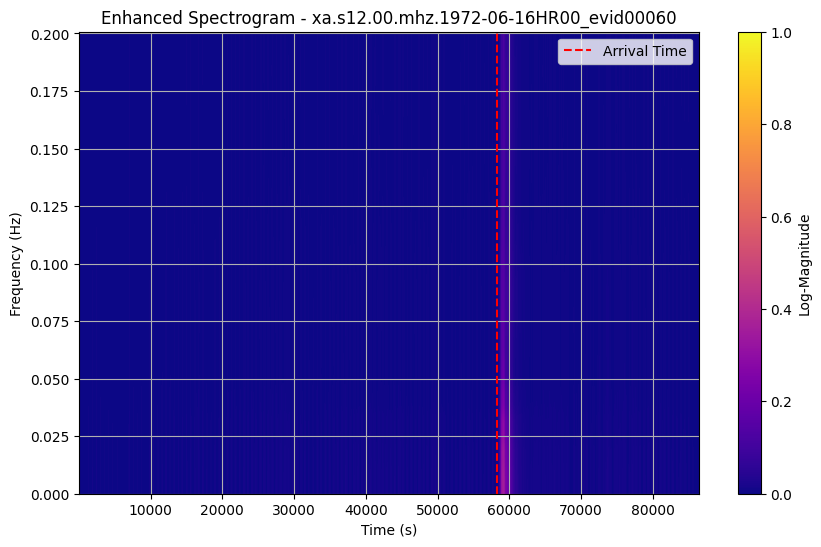

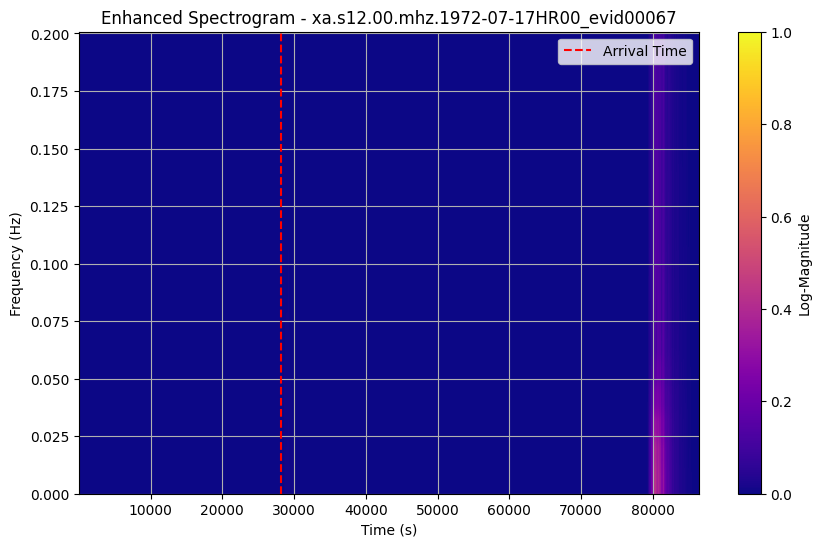

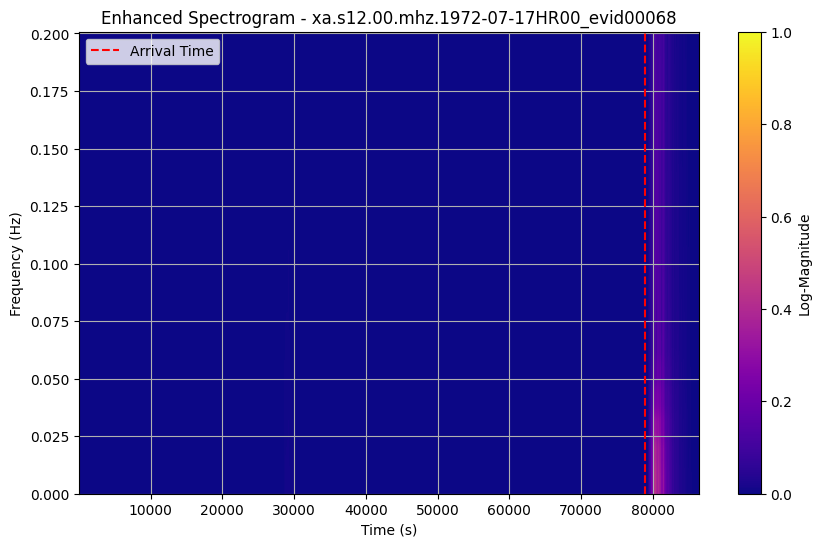

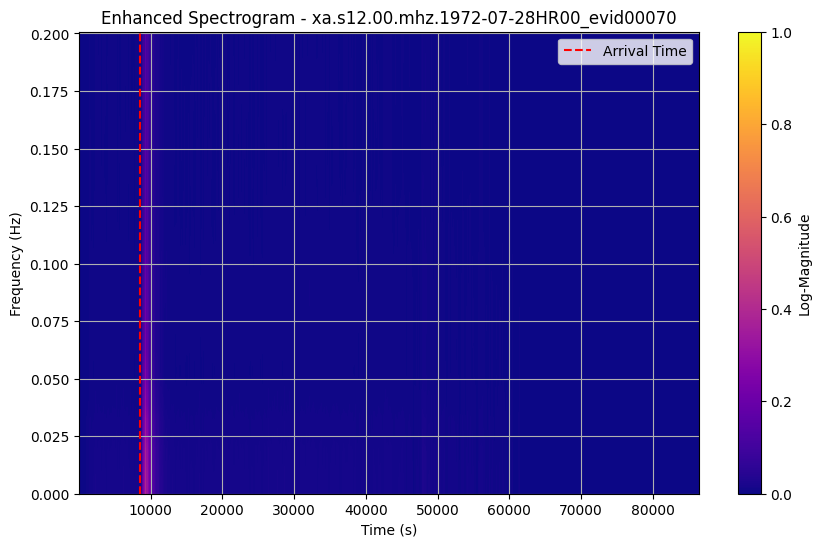

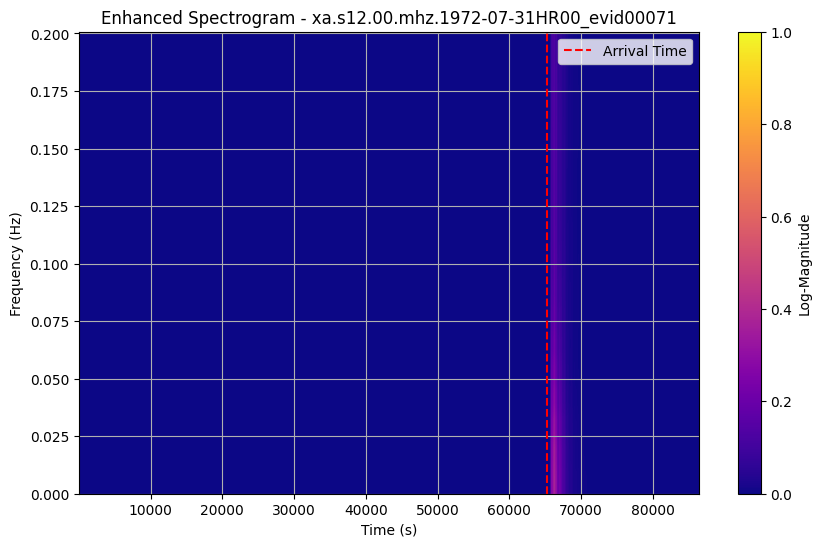

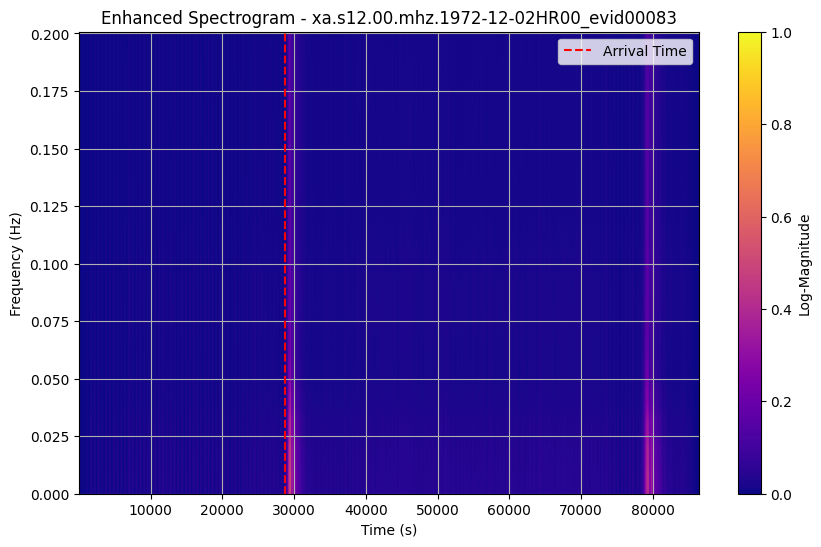

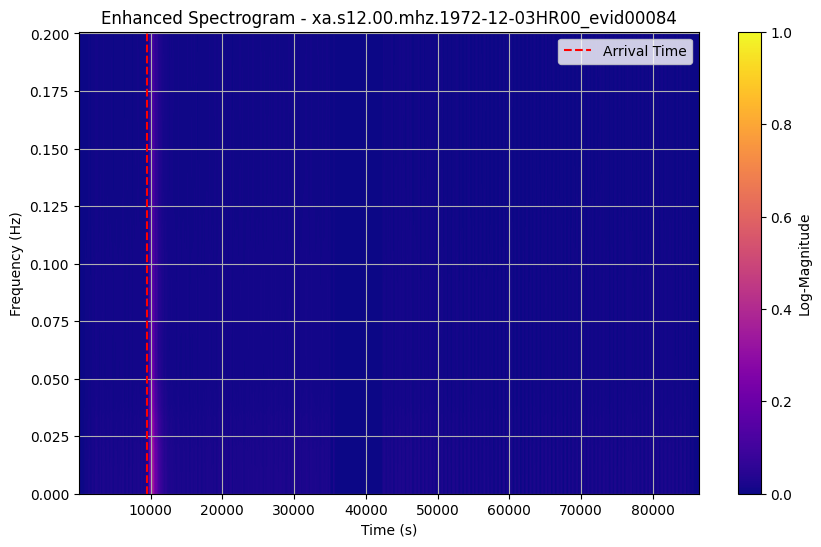

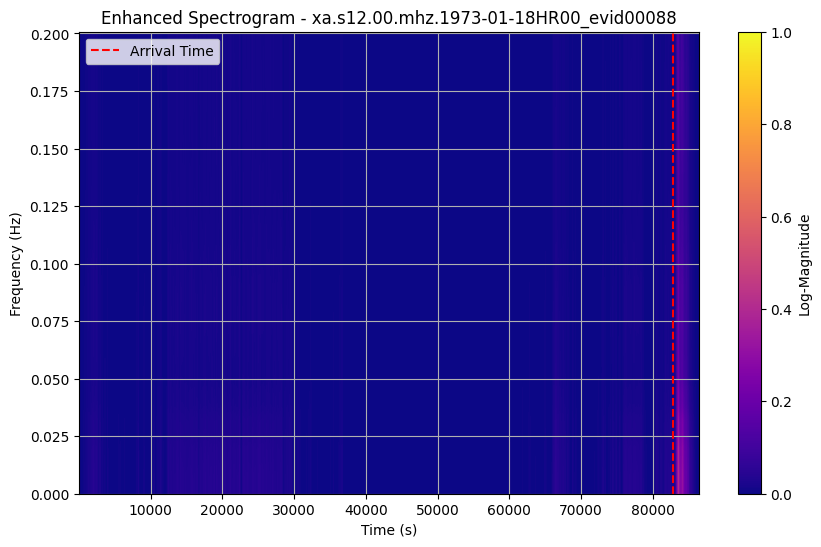

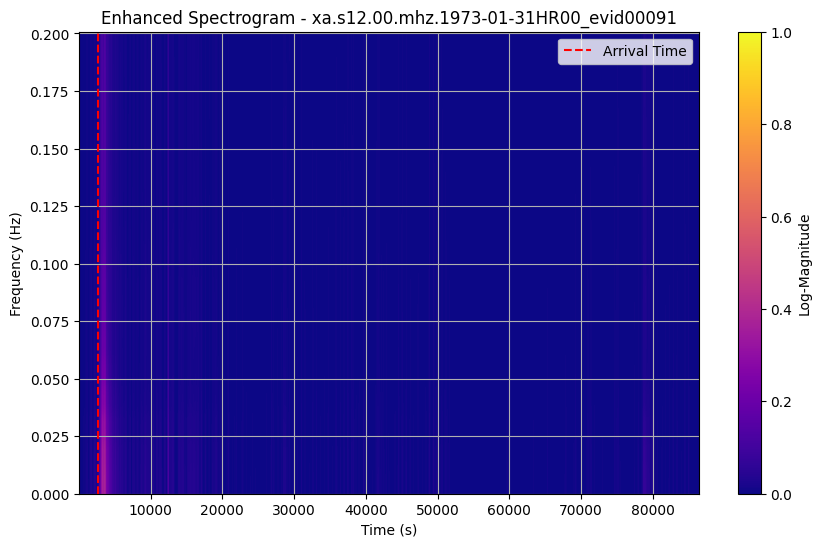

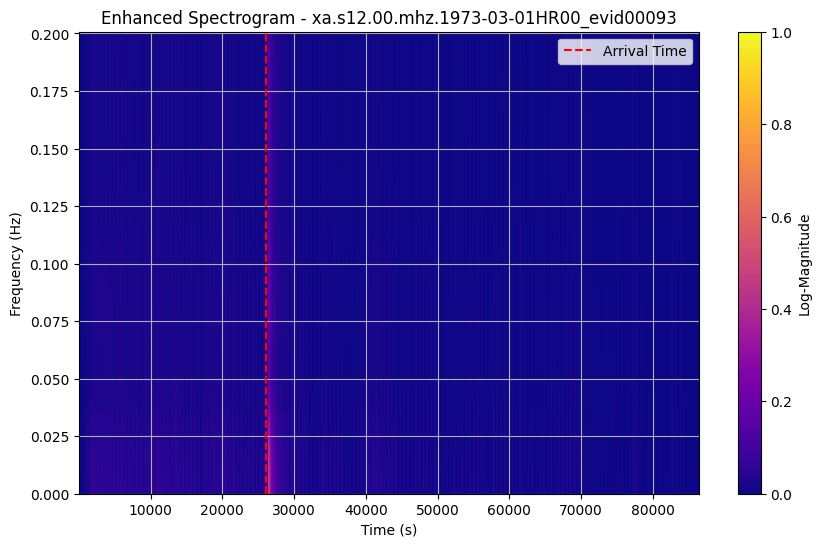

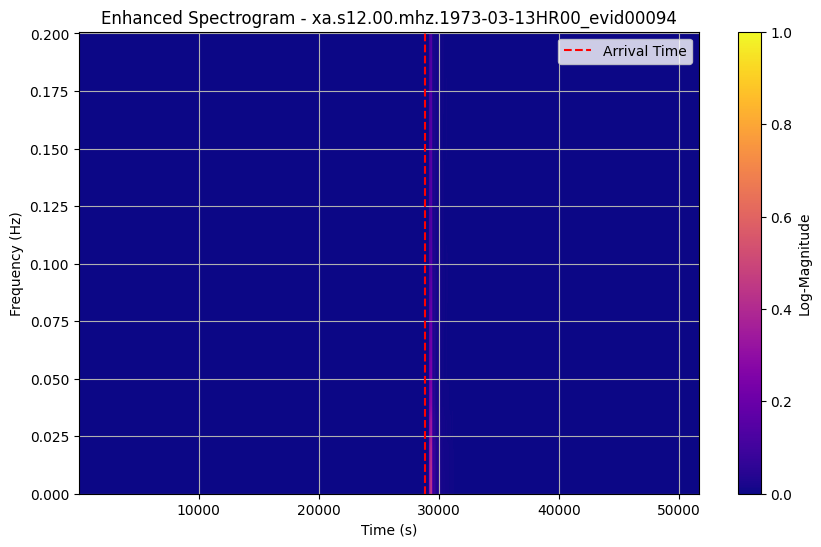

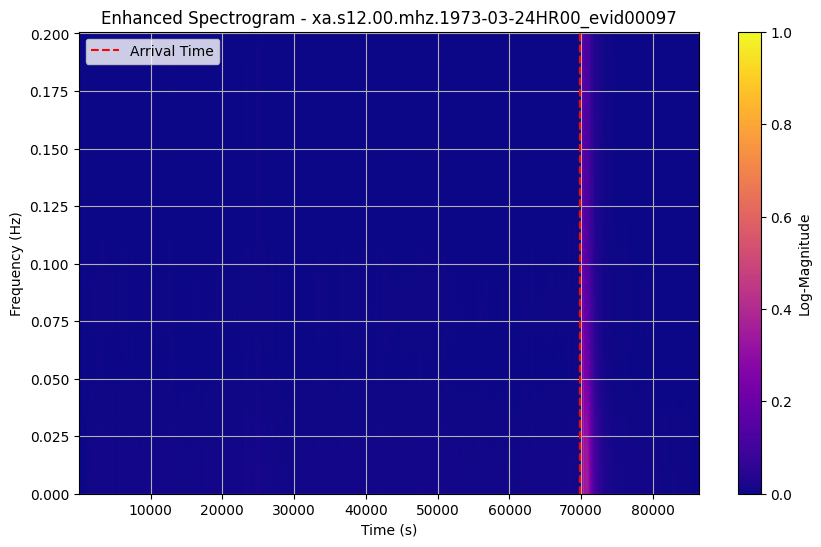

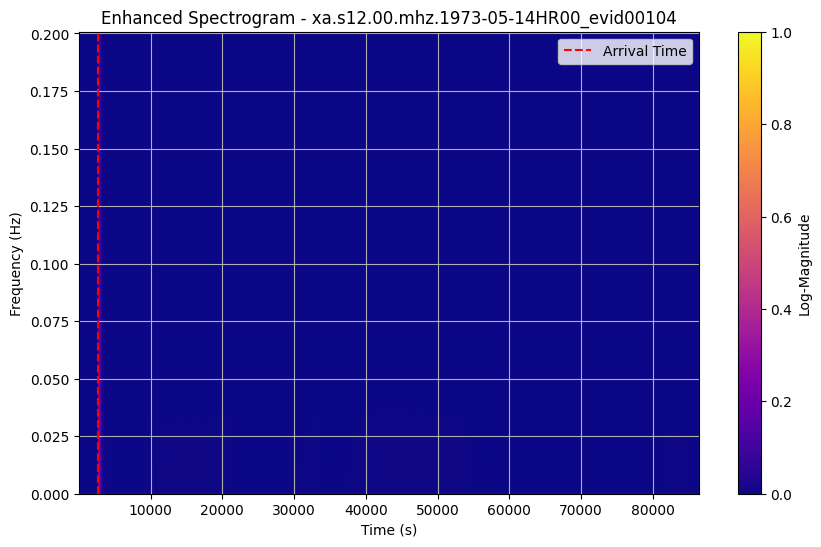

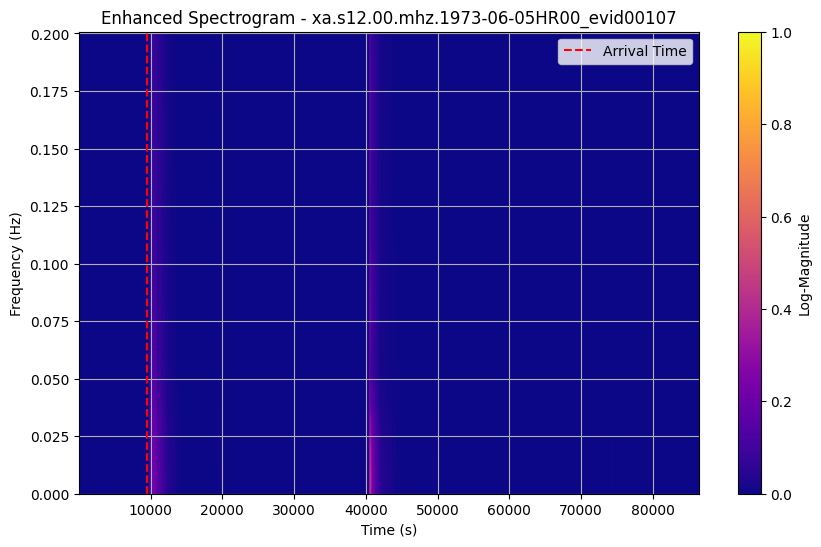

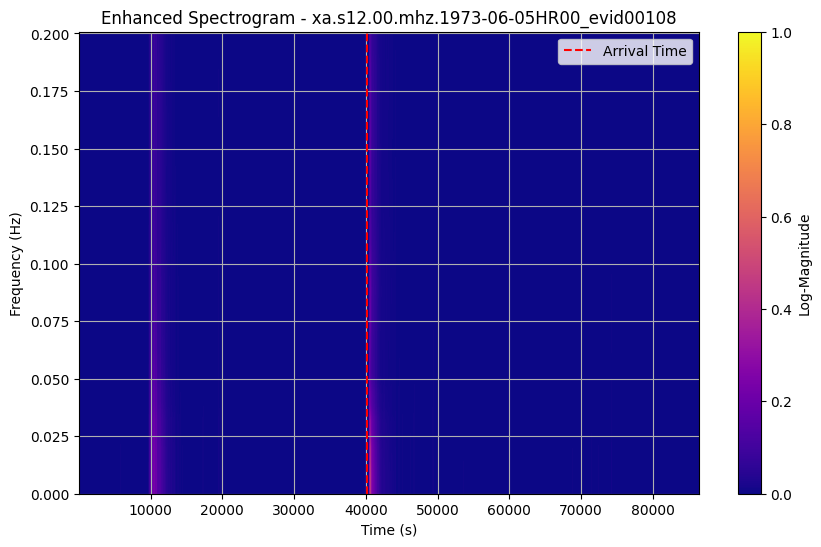

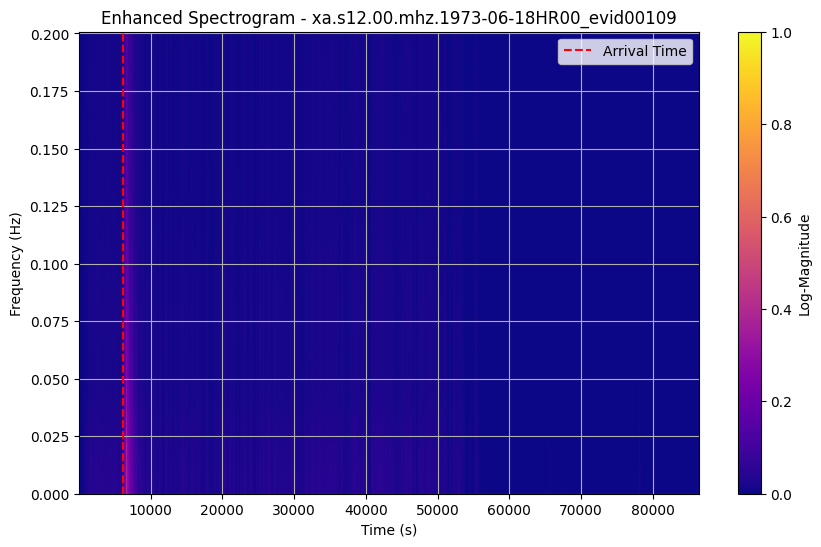

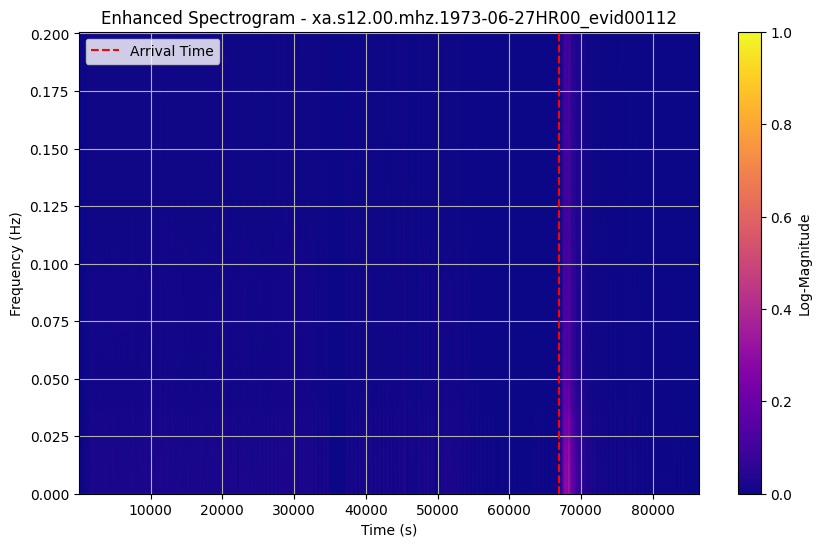

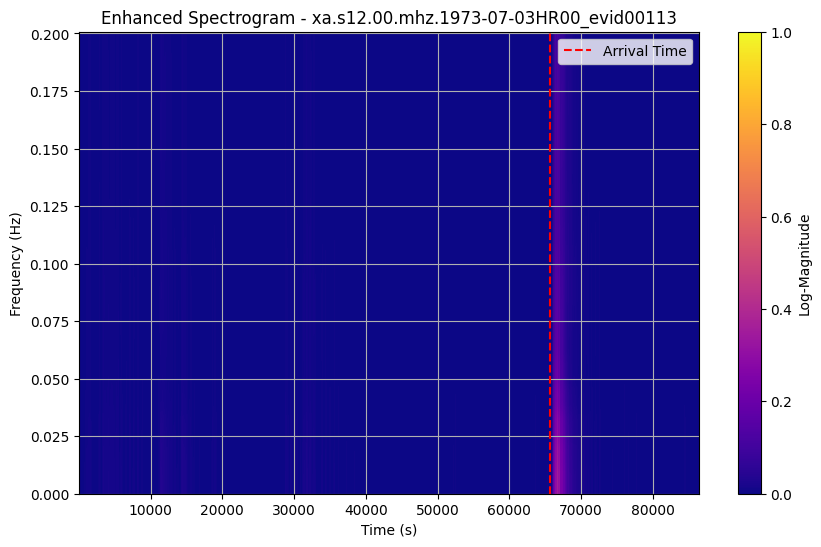

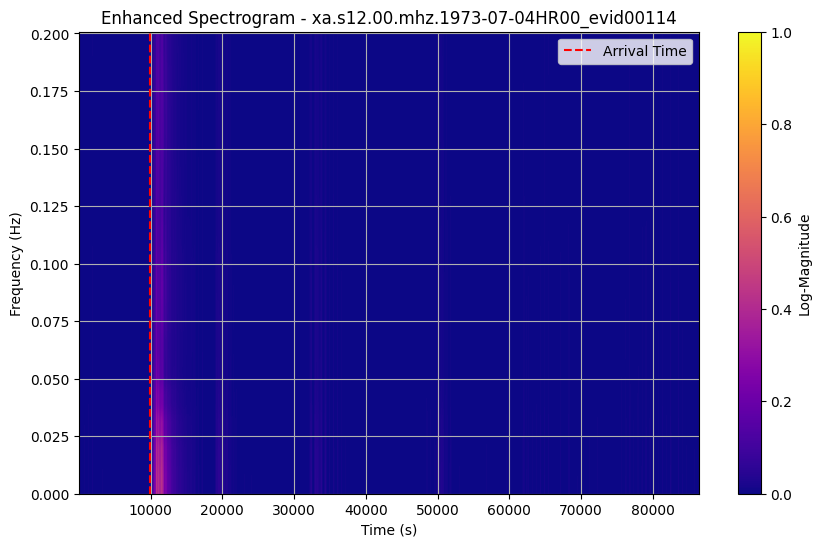

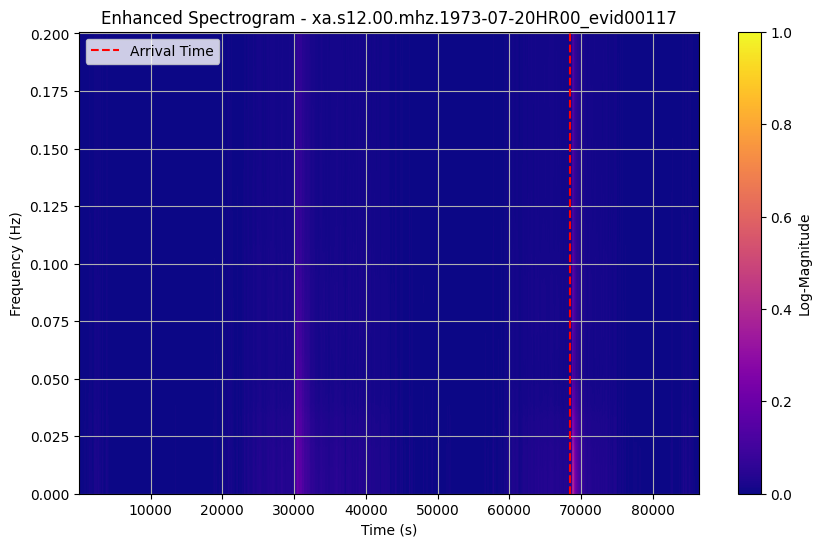

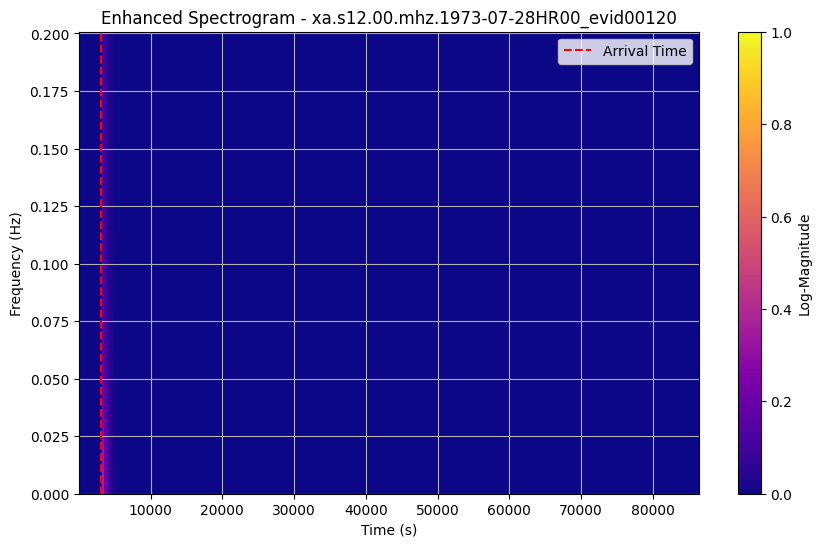

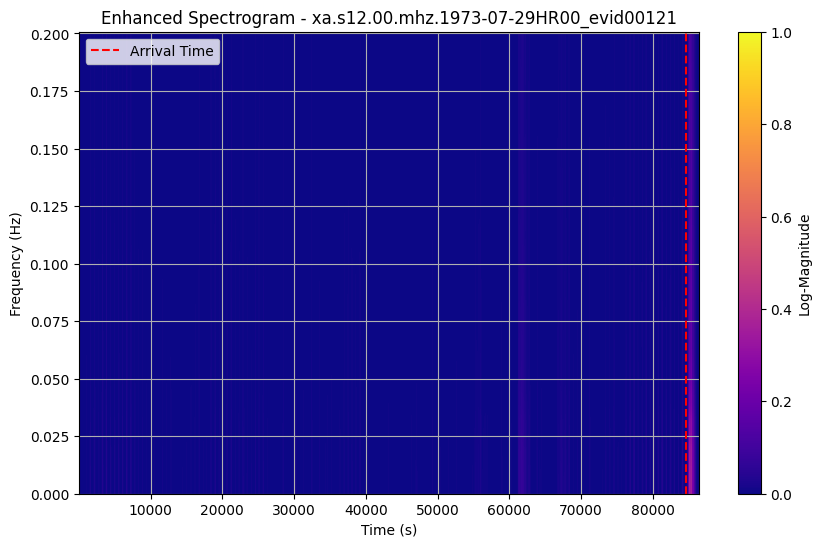

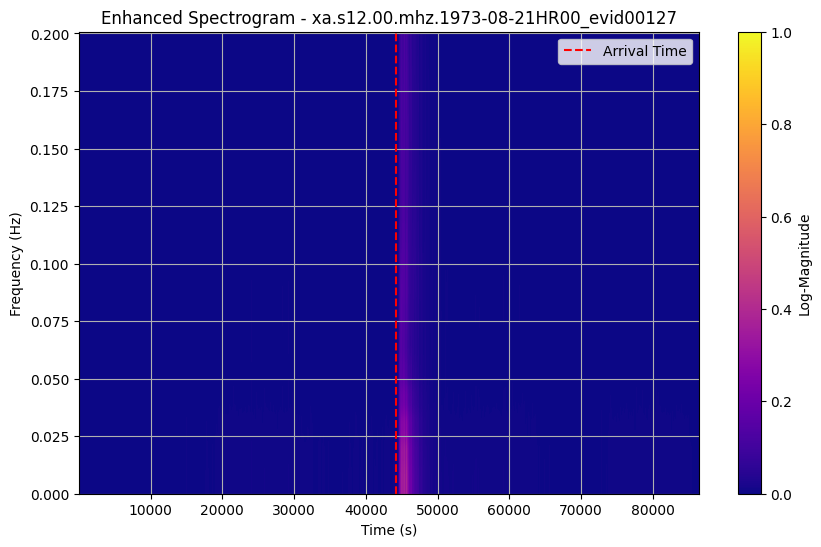

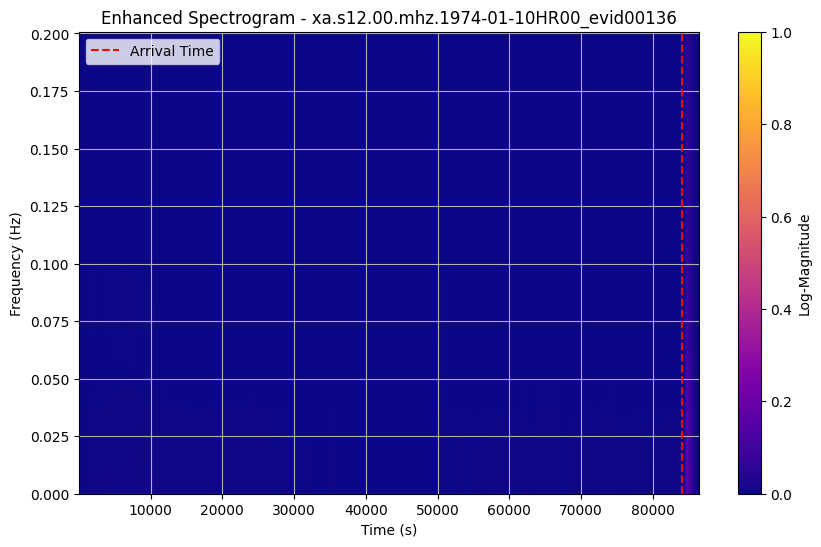

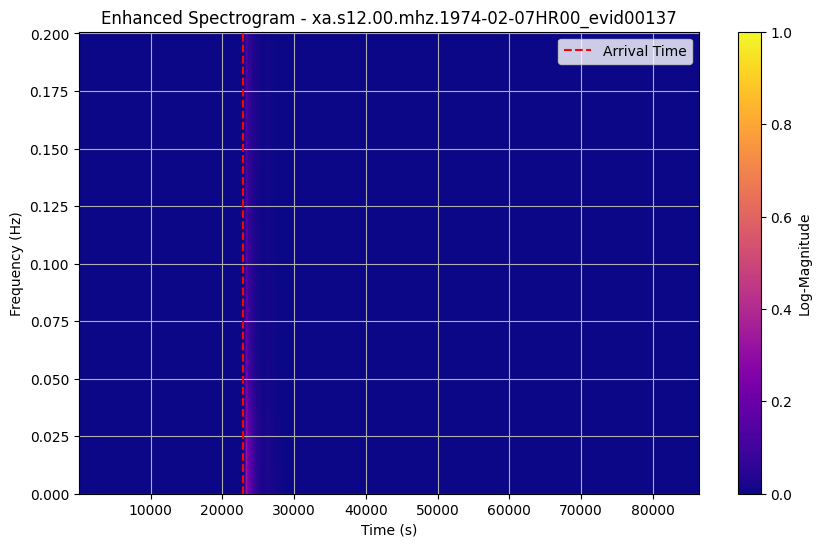

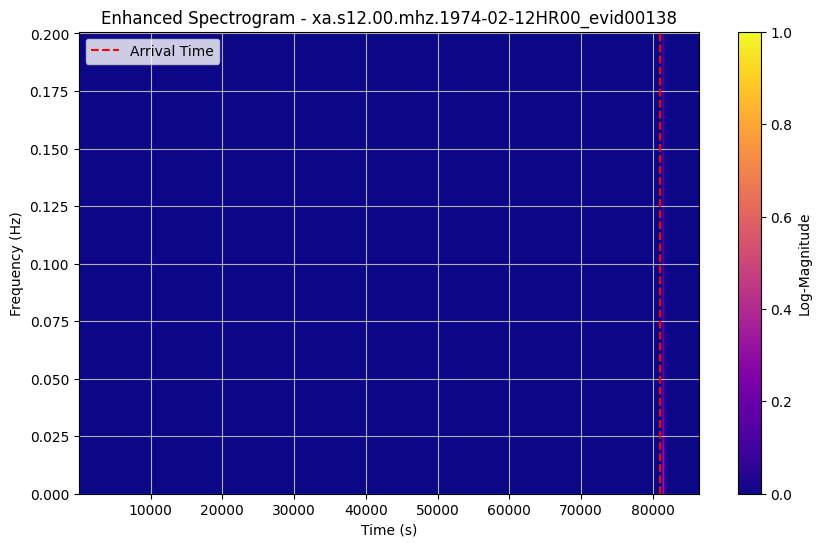

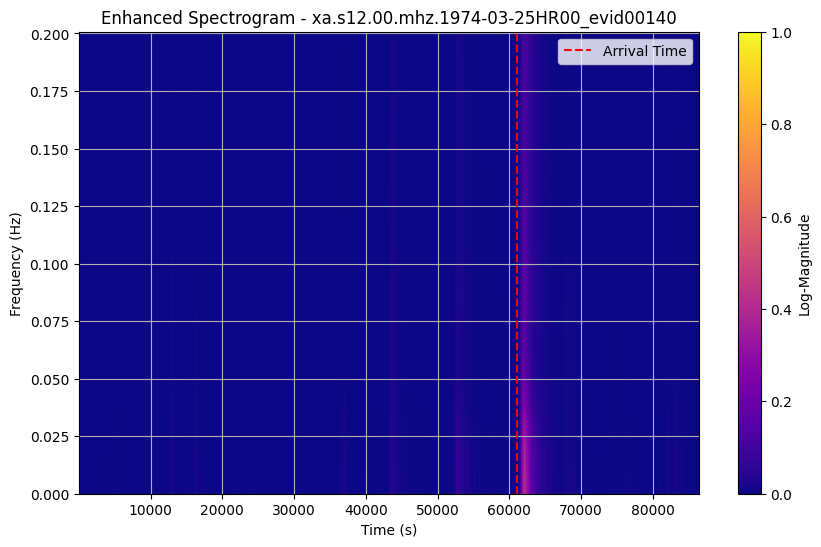

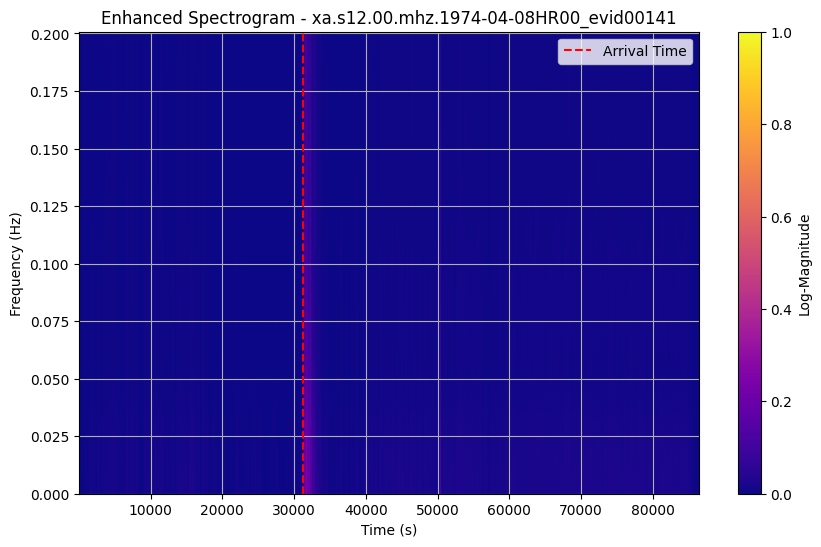

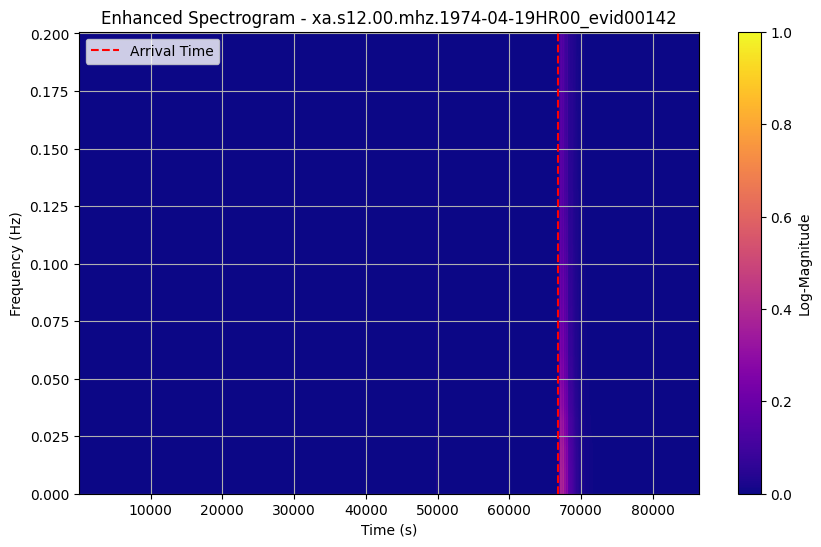

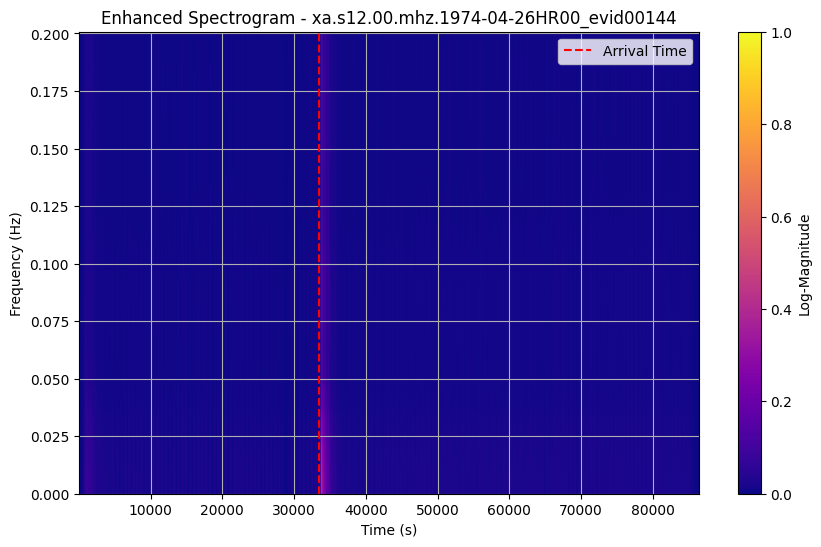

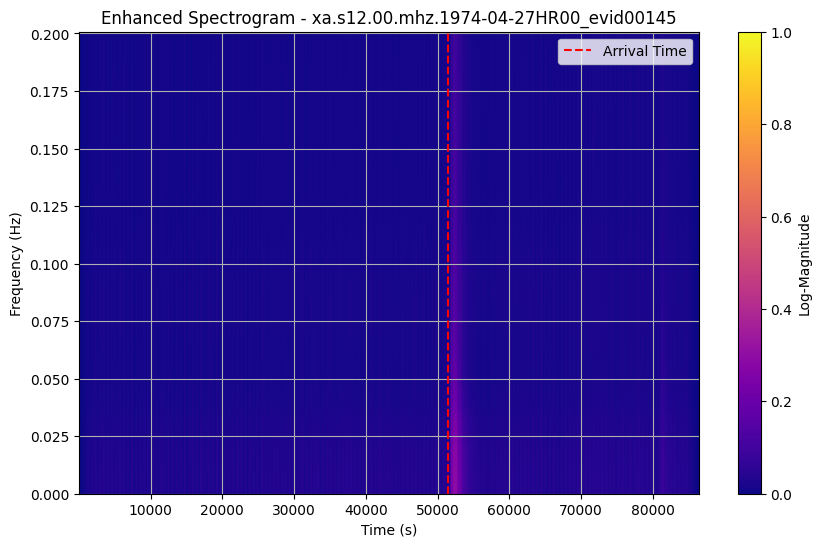

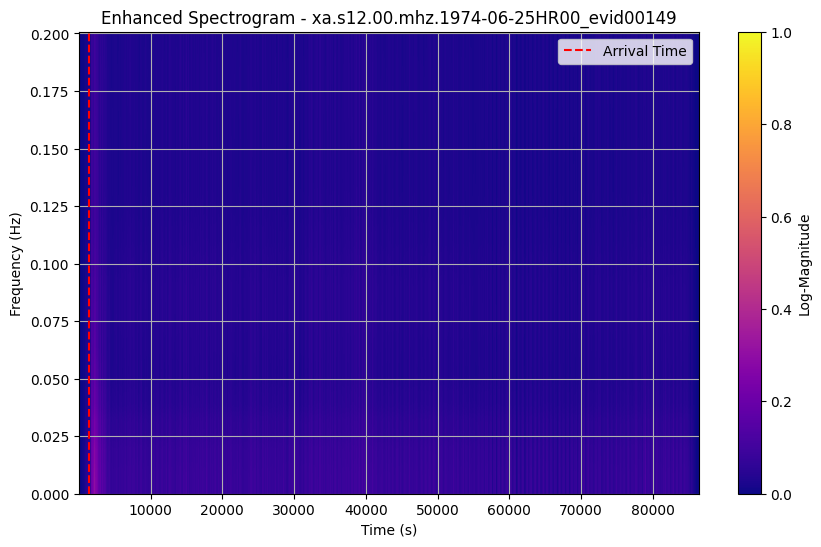

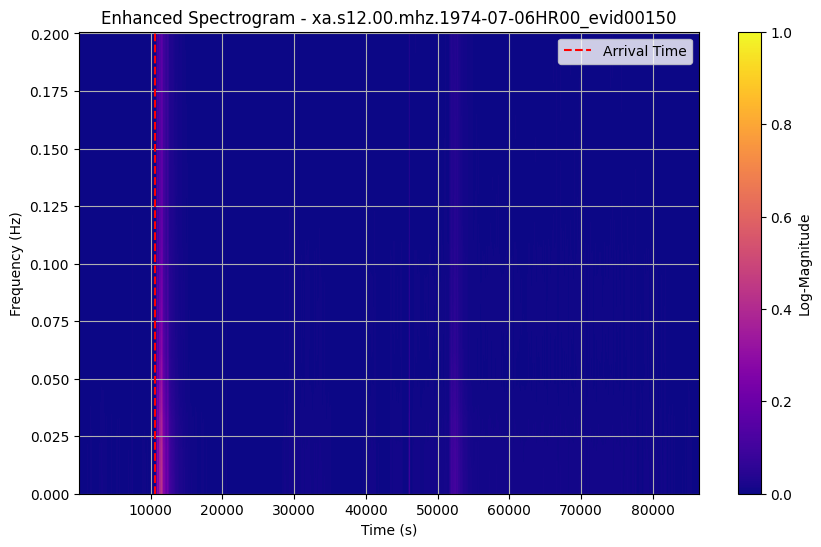

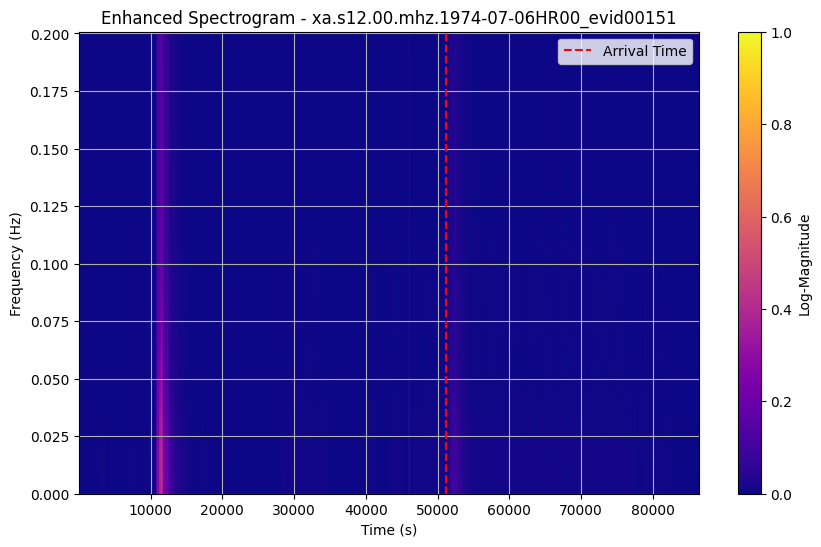

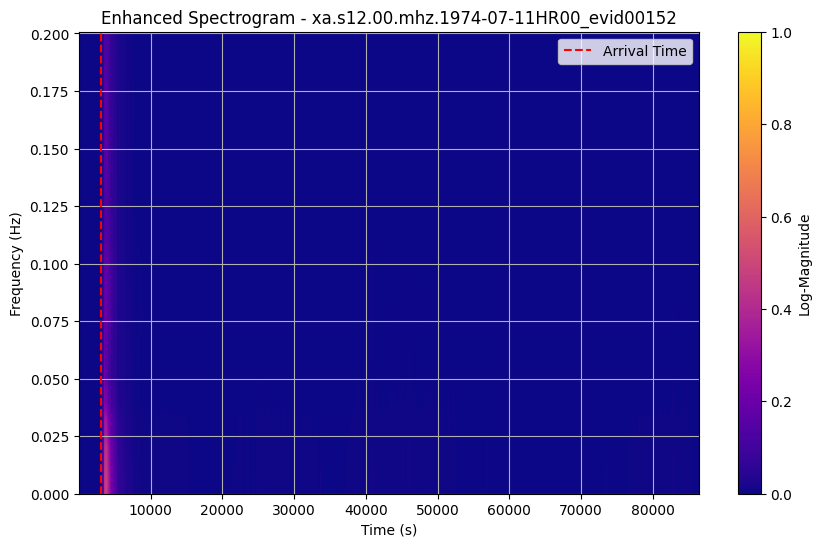

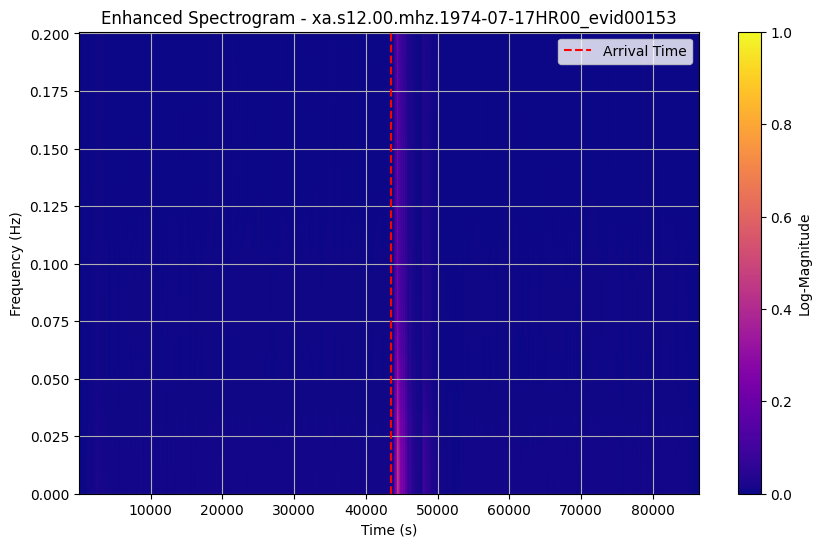

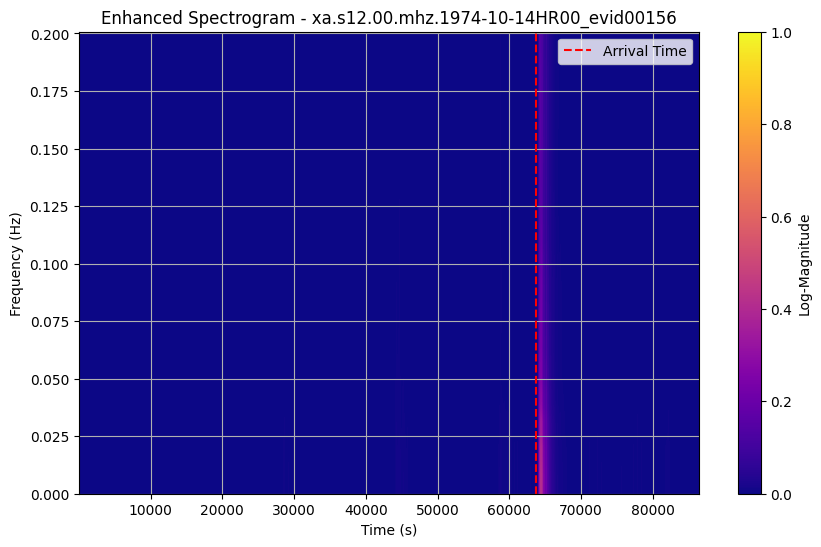

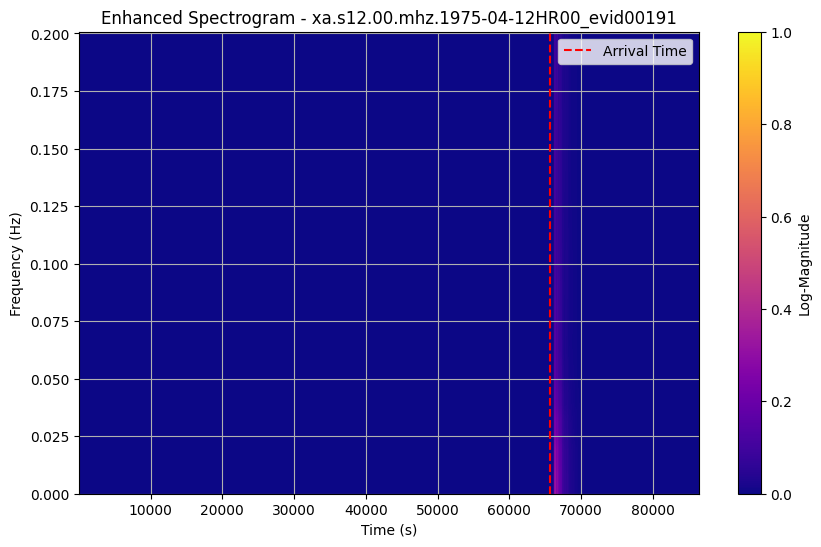

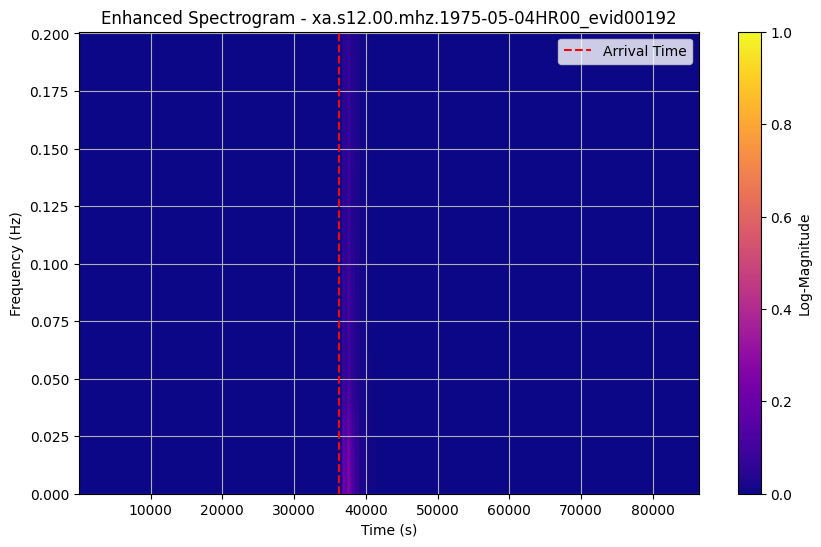

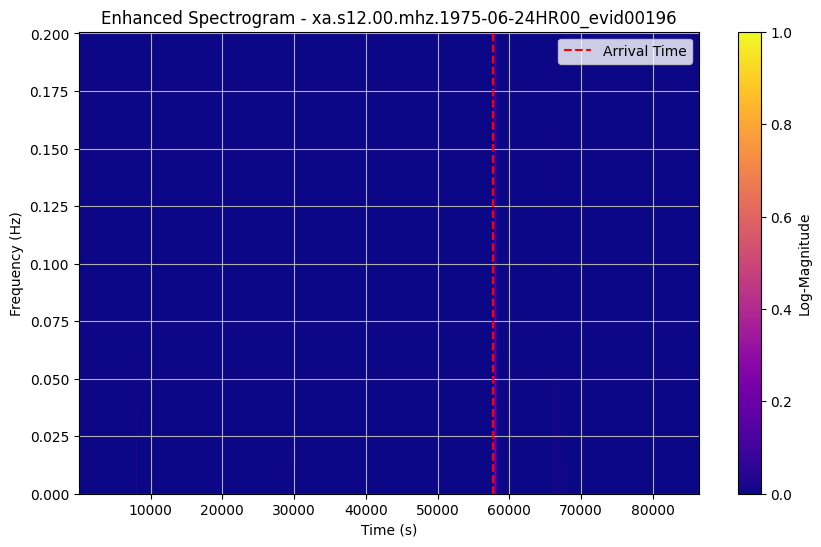

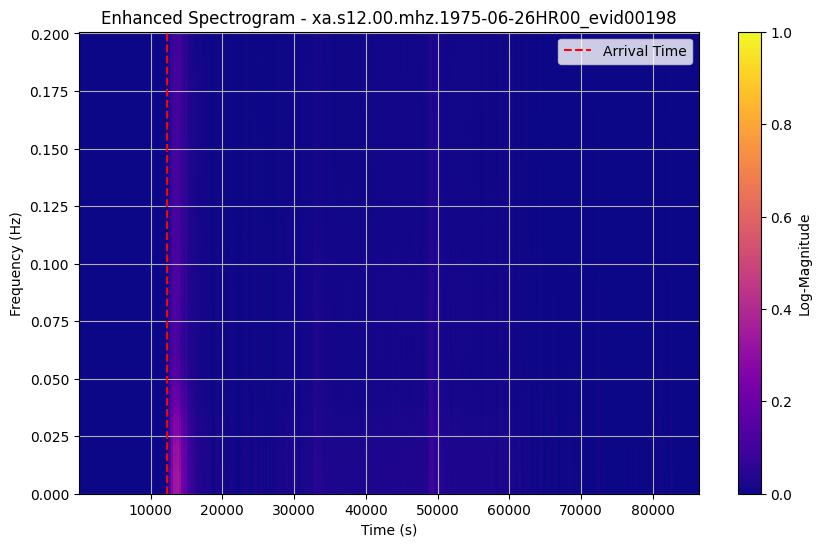

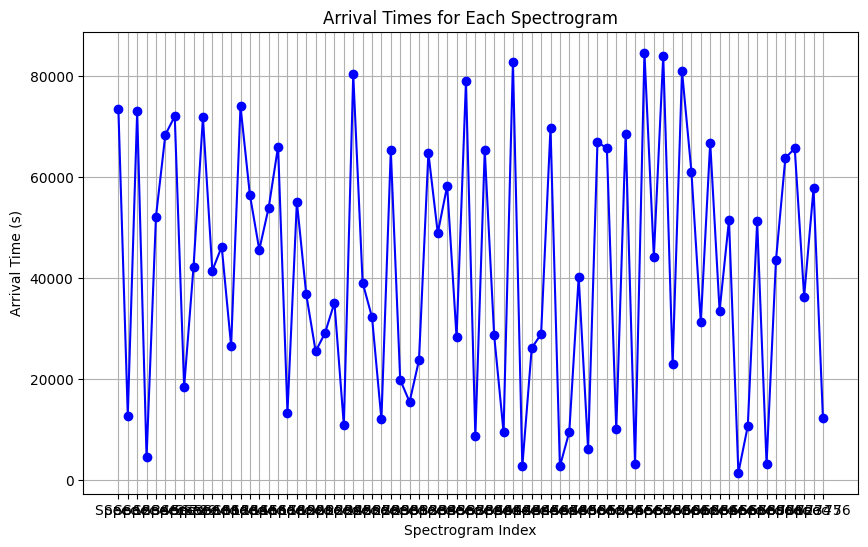

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from obspy import read
from datetime import datetime
import pandas as pd
from scipy import signal

cat_directory = './data/lunar/training/catalogs/'
cat_file = cat_directory + 'apollo12_catalog_GradeA_final.csv'
cat = pd.read_csv(cat_file)

max_relative_time = 86450
delta = 0.1509433962264151

nperseg = 64
noverlap = int(nperseg * 0.75)

spectrograms = []
arrival_times = []

for i in range(len(cat)):
    row = cat.iloc[i]
    arrival_time = datetime.strptime(row['time_abs(%Y-%m-%dT%H:%M:%S.%f)'], '%Y-%m-%dT%H:%M:%S.%f')
    test_filename = row['filename']
    
    data_directory = './data/lunar/training/data/S12_GradeA/'
    mseed_file = f'{data_directory}{test_filename}.mseed'
    st = read(mseed_file)

    tr = st.traces[0].copy()
    tr_data = tr.data

    minfreq = 0.3
    maxfreq = 1.5
    st.filter('bandpass', freqmin=minfreq, freqmax=maxfreq)
    tr_filt = st.traces[0].copy()
    tr_data_filt = tr_filt.data

    f, t, sxx = signal.spectrogram(tr_data_filt, tr_filt.stats.sampling_rate, nperseg=nperseg, noverlap=noverlap)
    
    spectrograms.append(sxx)
    arrival_times.append((arrival_time - tr.stats.starttime.datetime).total_seconds())

    freqs_spectrogram = np.fft.rfftfreq(sxx.shape[0], d=(t[1] - t[0]))
    fft_spectrogram = np.fft.rfft(sxx, axis=0)

    fft_spectrogram_log = np.log1p(np.abs(fft_spectrogram))

    fft_spectrogram_norm = (fft_spectrogram_log - np.min(fft_spectrogram_log)) / (np.max(fft_spectrogram_log) - np.min(fft_spectrogram_log))

    plt.figure(figsize=(10, 6))
    plt.imshow(fft_spectrogram_norm, aspect='auto', extent=[t[0], t[-1], freqs_spectrogram[0], freqs_spectrogram[-1]], origin='lower', cmap='plasma')
    plt.colorbar(label='Log-Magnitude')
    plt.axvline(x=arrival_times[-1], color='red', linestyle='--', label='Arrival Time')
    plt.title(f'Enhanced Spectrogram - {test_filename}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.legend()
    plt.grid()
    plt.show()

plt.figure(figsize=(10, 6))
plt.plot(arrival_times, marker='o', linestyle='-', color='blue')
plt.title('Arrival Times for Each Spectrogram')
plt.xlabel('Spectrogram Index')
plt.ylabel('Arrival Time (s)')
plt.grid()
plt.xticks(ticks=np.arange(len(arrival_times)), labels=[f'Spec {i+1}' for i in range(len(arrival_times))])
plt.show()
